# 0.0 - Imports

In [1]:
import math
import pickle
import random
import warnings
import datetime
import inflection

import numpy               as np
import pandas              as pd
import xgboost             as xbg
import seaborn             as sns
import matplotlib.pyplot   as plt

from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.core.display  import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from scipy                 import stats as ss

## 0.1 - Helper Functions

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    #pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

In [4]:
def set_pubfig():
    sns.set_context("paper", rc={"font.size":15,"axes.titlesize":20,"axes.labelsize":20}, font_scale=1.4) 

set_pubfig()

In [5]:
def cross_validation(x_training, k_fold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, k_fold+1)):
        if verbose:
            print(f'KFold Number: {k}')
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #predictions
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0] )


def mean_percentage_error_2(y, yhat):
    return np.mean( (y - yhat) /y )


def mean_absolute_percentage_error_2(y, yhat):
    MAPE = np.abs( (y - yhat) /y )
    return np.mean(MAPE[np.isfinite(MAPE)])


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error_2(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])



def cramer_v(x, y):
    cm = pd.crosstab(x, y).values #as_matrix() saiu do pandas
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k -1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = r - (r -1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )



## 0.2 - Loading data

In [6]:
import pandas as pd

In [7]:
df_sales_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\store.csv', low_memory=False)

In [8]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - PASSO 01 - Descrição dos dados

In [9]:
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [10]:
df1['Date'].max()

'2015-07-31'

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 - Data Dimensions

In [12]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [13]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

### 1.5.1 - competition_distance 

In [15]:
#-> Assumption: Como o maior valor da coluna 'competition_distance' é 75.860, será estabelecido 200.000 para os casos que tiverem NA na coluna 'competition_distance'
#   Buscando manter o máximo de dados possíveis para a análise (onde 200mil seria equivalente ao mínimo de concorrência possível)

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

### 1.5.2 - competition_open_since_month

In [16]:
#-> Assumption: Como não é possível saber porque está com NA, identificamos que pode ser porque não existe competidor ou ocompetidor abriu antes da loja
#   Desta forma será estabelecido o mesmo mês apresentado na coluna 'date', mantendo assim um intervalo entre as datas igual a 0 

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

### 1.5.3 - competition_open_since_year

In [17]:
#-> Assumption 3: Mesma lógica que o Assumption para o 'competition_open_since_month'

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### 1.5.4 - promo2_since_week

In [18]:
#-> Assumption: Se está é NA é porque a loja não participou da promoção 2, manteremos a data informada na coluna 'date' (promo_time_week será igual a 0)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

### 1.5.5 - promo2_since_year

In [19]:
#-> Assumption: Mesma lógica que o Assumption para o 'promo2_since_week'
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### 1.5.6 - promo_interval

In [20]:
df1['promo_interval'].fillna(0, inplace=True)

### 1.5.7 - Confirming fillout NA

In [21]:
df1.isna().sum()### 1.5.6 - promo_interval

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

In [25]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.6 - Change Types

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 - Descriptive Statistics

In [21]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numeric Attributes

In [22]:
#central tendency - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
ed_table = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ed_table.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [23]:
ed_table

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 - Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

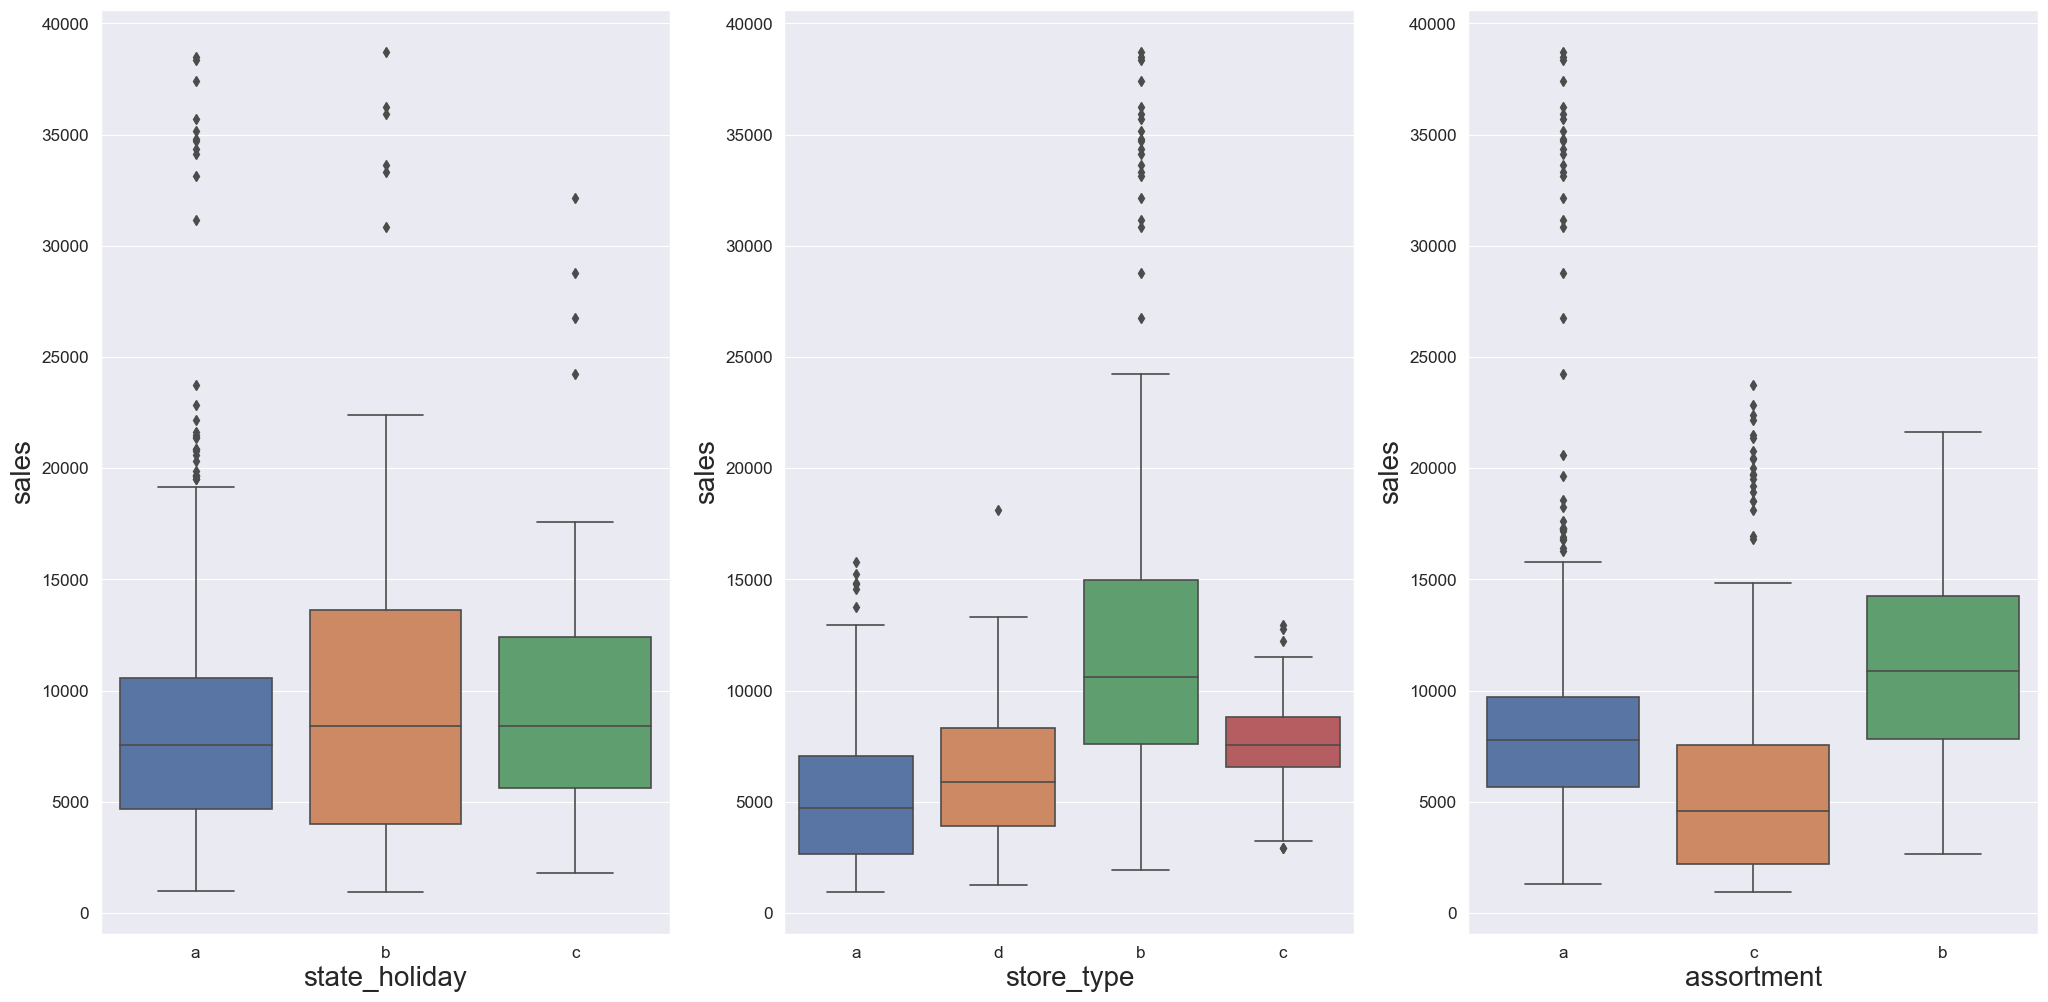

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

**state_holiday**
- O feriado **a** possui mais outliers e uma concentração de valores das vendas mais baixo entre os feriados
- O feriado **b** possui a maior variação dos valores de vendas
- O feriado **c** possui a maior concentração em valores de vendas altos contando com poucos outliers

**store_type**
- A loja do tipo **a** possui a menor mediana concentrando os menores valores de vendas entre as lojas
- A loja do tipo **d** muito semelhante a loja **a** mas com um concentração de valores de vendas um pouco superior
- A loja do tipo **b** possui a disperção dos valores de venda, a maior mediana e mais outliers entre os tipos de lojas
- A loja do tipo **c** possui a maior concentração de velores de vendas entre lojas, mas conta com a segunda maior mediana

**assortment**
- O feriado **a** possui mais outliers
- O feriado **c** possui uma concentração de valores de vendas inferior aos demais
- O feriado **b** possui a maior mediana com uma concentração de valores de vendas superior as demais

# 2.0 - PASSO 02 - Feature Engineering

In [26]:
df2 = df1.copy()

## 2.1 - Mapa mental de Hipóteses

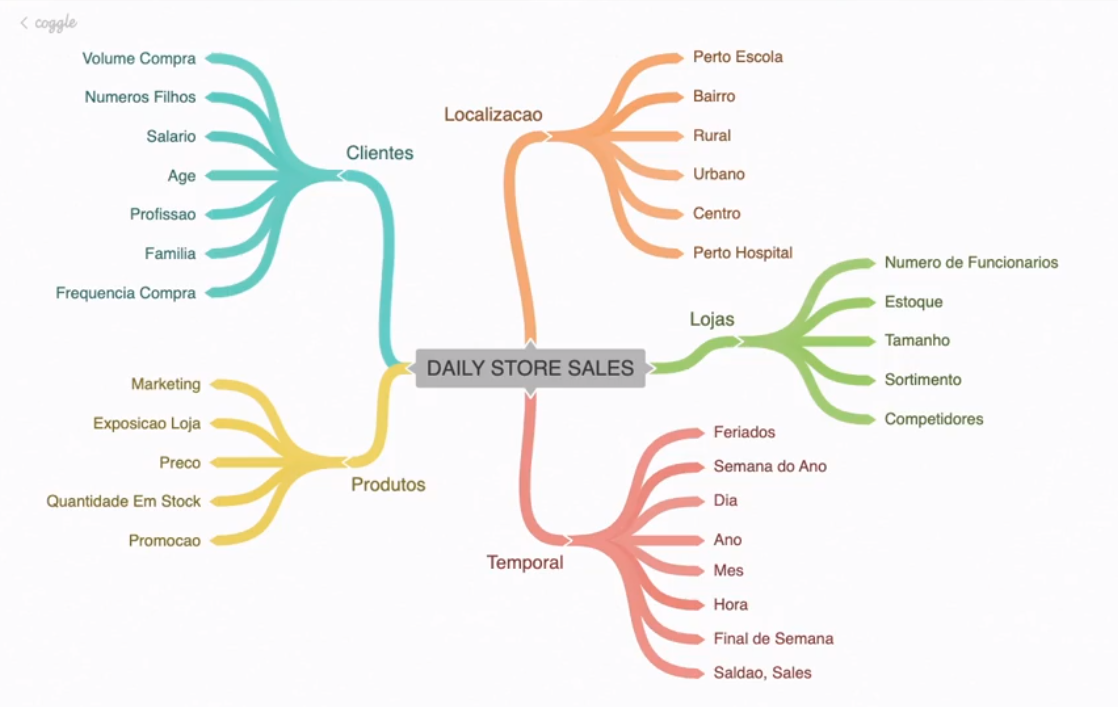

In [27]:
Image('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto//img//mind_map_hypothesis.png')

## 2.2 - Criação das Hipóteses

### 2.2.1 - Hipóteses loja

**1.** Lojas com um **maior quadro de funcionários** deveriam **vender mais**

**2.** Lojas com **maior estoque** deveriam **vender mais**

**3.** Lojas com **maior porte** deveriam **vender mais**

**4.** Lojas com **menor porte** deveriam **vender menos**

**5.** Lojas com **maior sortiment**o deveriam **vender mais**

**6.** Lojas com **competidores mais próximos** deveriam **vender menos**

**7.** Lojas com **competidores à mais tempo** deveriam **vender mais**

### 2.2.2 - Hipóteses produto

**1.** Lojas investem mais em **marketing** deveriam **vender mais**

**2.** Lojas com maior **exposição de produtos** deveriam **vender mais**

**3.** Lojas que tem **preços menores** nos produtos deveriam **vender mais**

**4.** Lojas que tem **promoções mais agressivas** (descontos maiores) deveriam **vender mais**

**5.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**6.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**7.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

### 2.2.3 - Hipóteses Tempo

**1.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**2.** Lojas deveriam **vender mais** ao **longo dos anos**

**4.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**5.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**6.** Lojas deveriam **vender menos** aos **finais de semana**

**7.** Lojas deveriam **vender menos** durante os **feriados escolares**





### 2.3 - Lista Final de Hipóteses 

**1.** Lojas com **maior sortimento** deveriam **vender mais**

**2.** Lojas com **competidores mais próximos** deveriam **vender menos**

**3.** Lojas com **competidores à mais tempo** deveriam **vender mais**

**4.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**5.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**6.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

**7.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**8.** Lojas deveriam **vender mais** ao **longo dos anos**

**9.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**10.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**11.** Lojas deveriam **vender menos** aos **finais de semana**

**12.** Lojas deveriam **vender menos** durante os **feriados escolares**

## 2.4 - Feature Engineering

### 2.4.1 - Creating new features

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)

# competition time month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo2 since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# promo 2 time week
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since'])/7).apply(lambda x: x.days).astype(int)

# month map
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df2['month_map'] = df2['date'].dt.month.map(month_map)

# promo interval
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if  x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 2.4.2 - Ajusting features

In [29]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 - PASSO 03 - Filtragem de variáveis

In [30]:
df3 = df2.copy()

## 3.1 - Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] != 0)]

## 3.2 - Seleção das colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - PASSO 04 - Análise Exploratória dos dados

In [33]:
df4 = df3.copy()
num_attributes2 = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes2 = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 - Análise Univariada

### 4.1.1 - Response variable

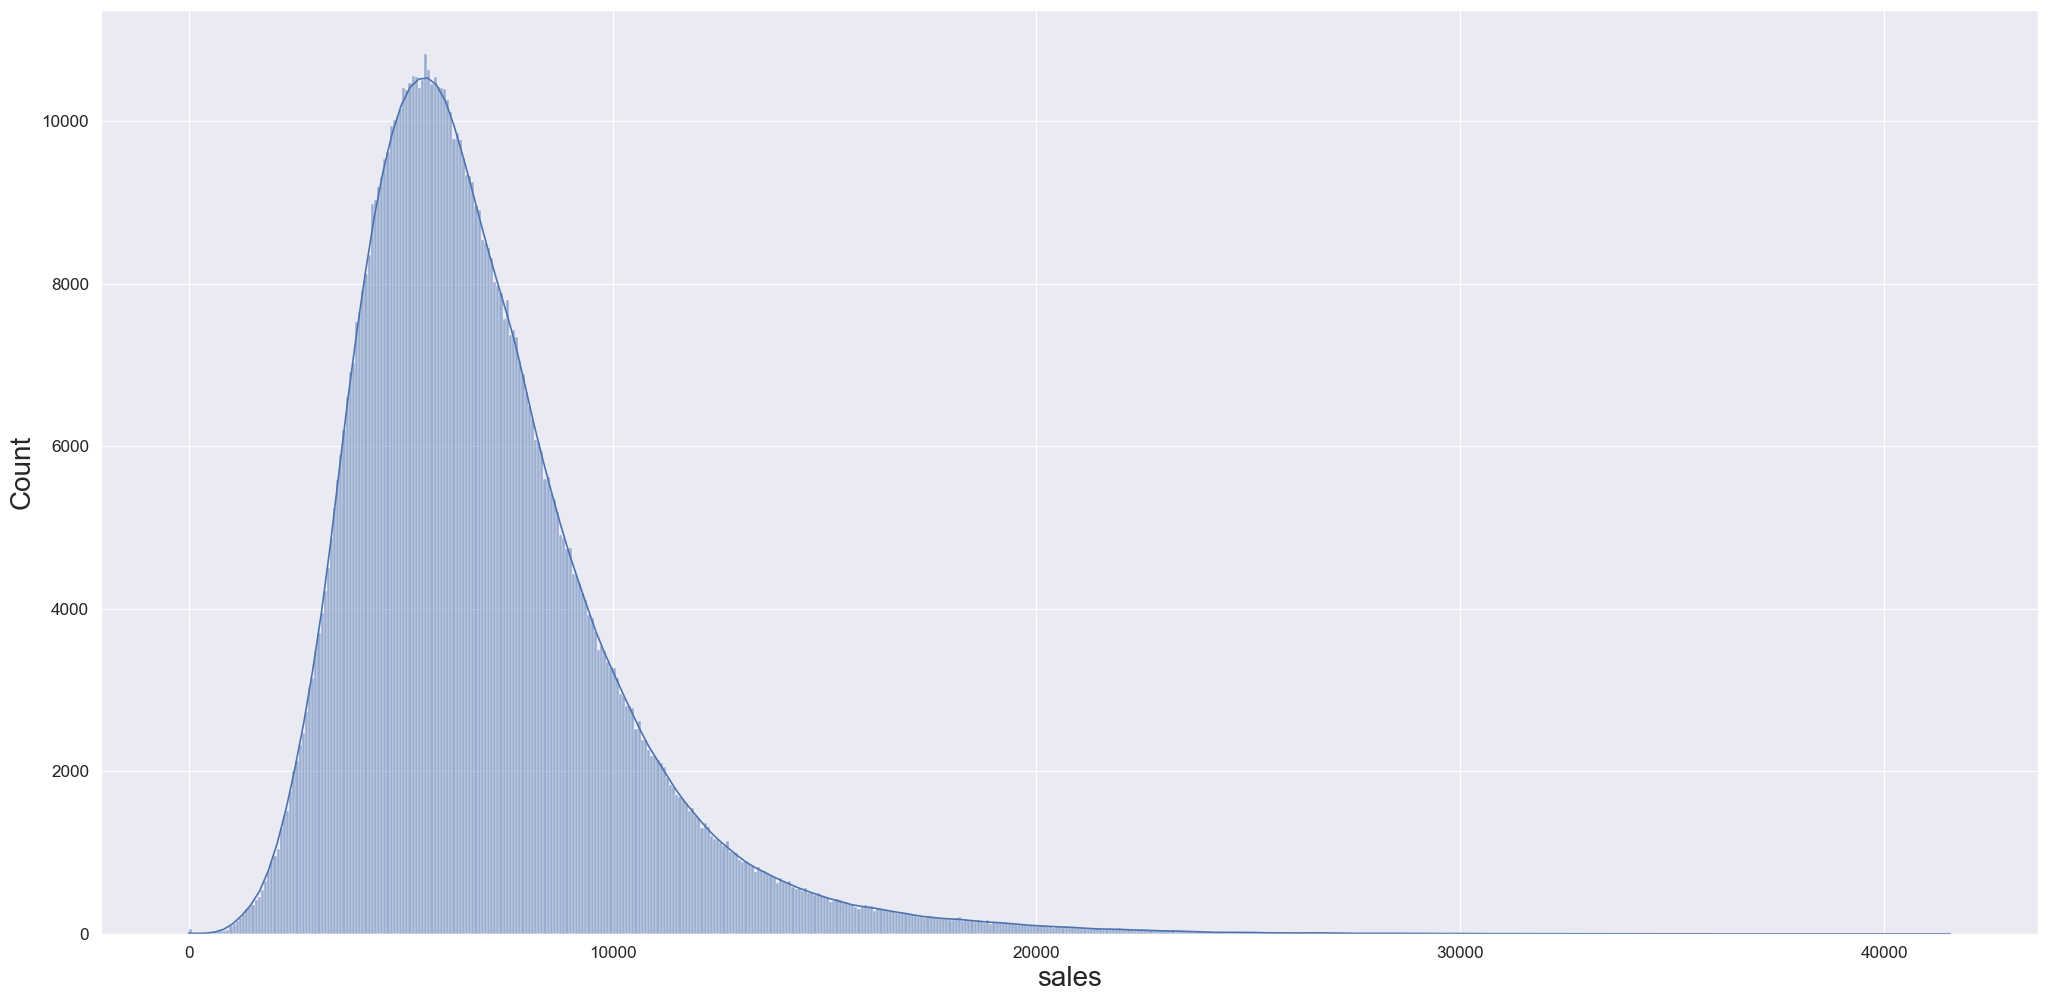

In [34]:
sns.histplot(df4['sales'], kde=True);

### 4.1.2 - Numeriacal variable

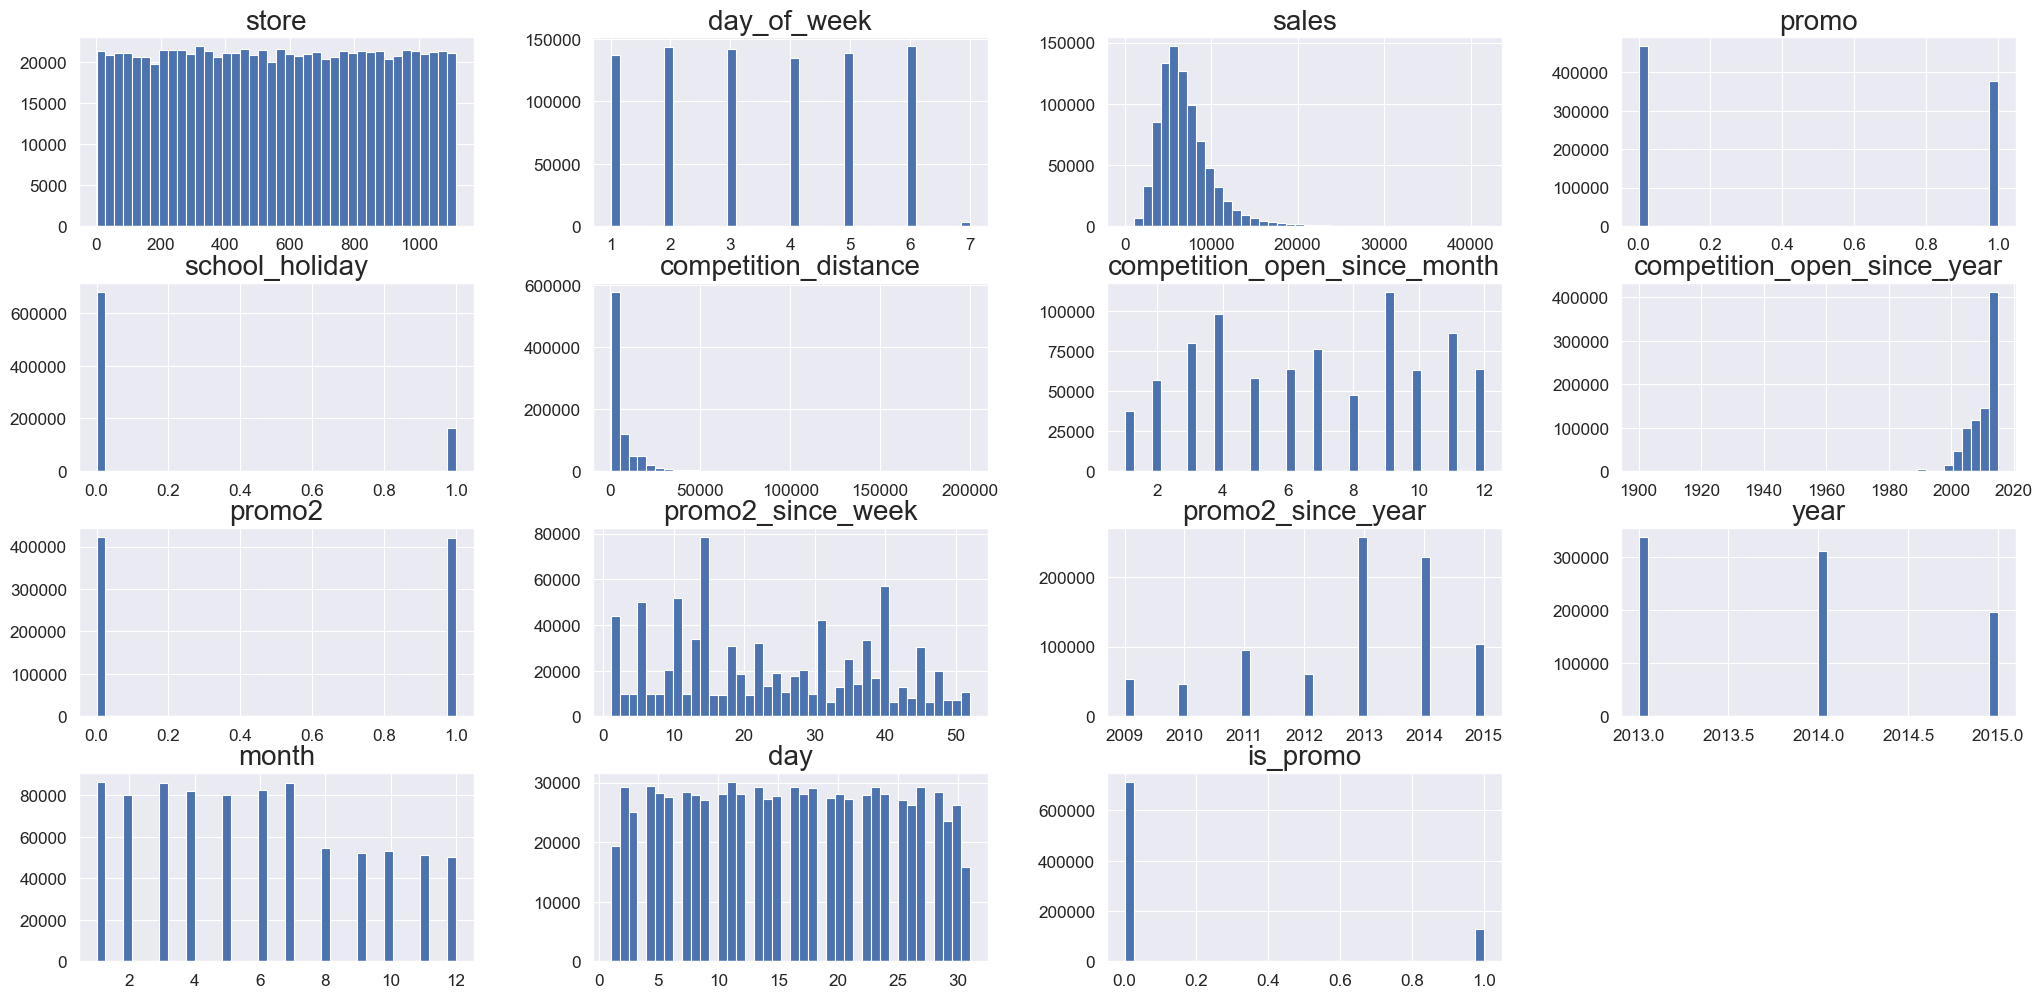

In [35]:
num_attributes2.hist(bins=40);

In [36]:
aux1 = df4[df4['competition_open_since_year'] < 1990]
aux2 = aux1['store'].unique()
print(f'Apenas 2 lojas possuem um concorrente aberto antes de 1990, são elas: {aux2}')

Apenas 2 lojas possuem um concorrente aberto antes de 1990, são elas: [146 815]


### 4.1.3 - Categorical variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

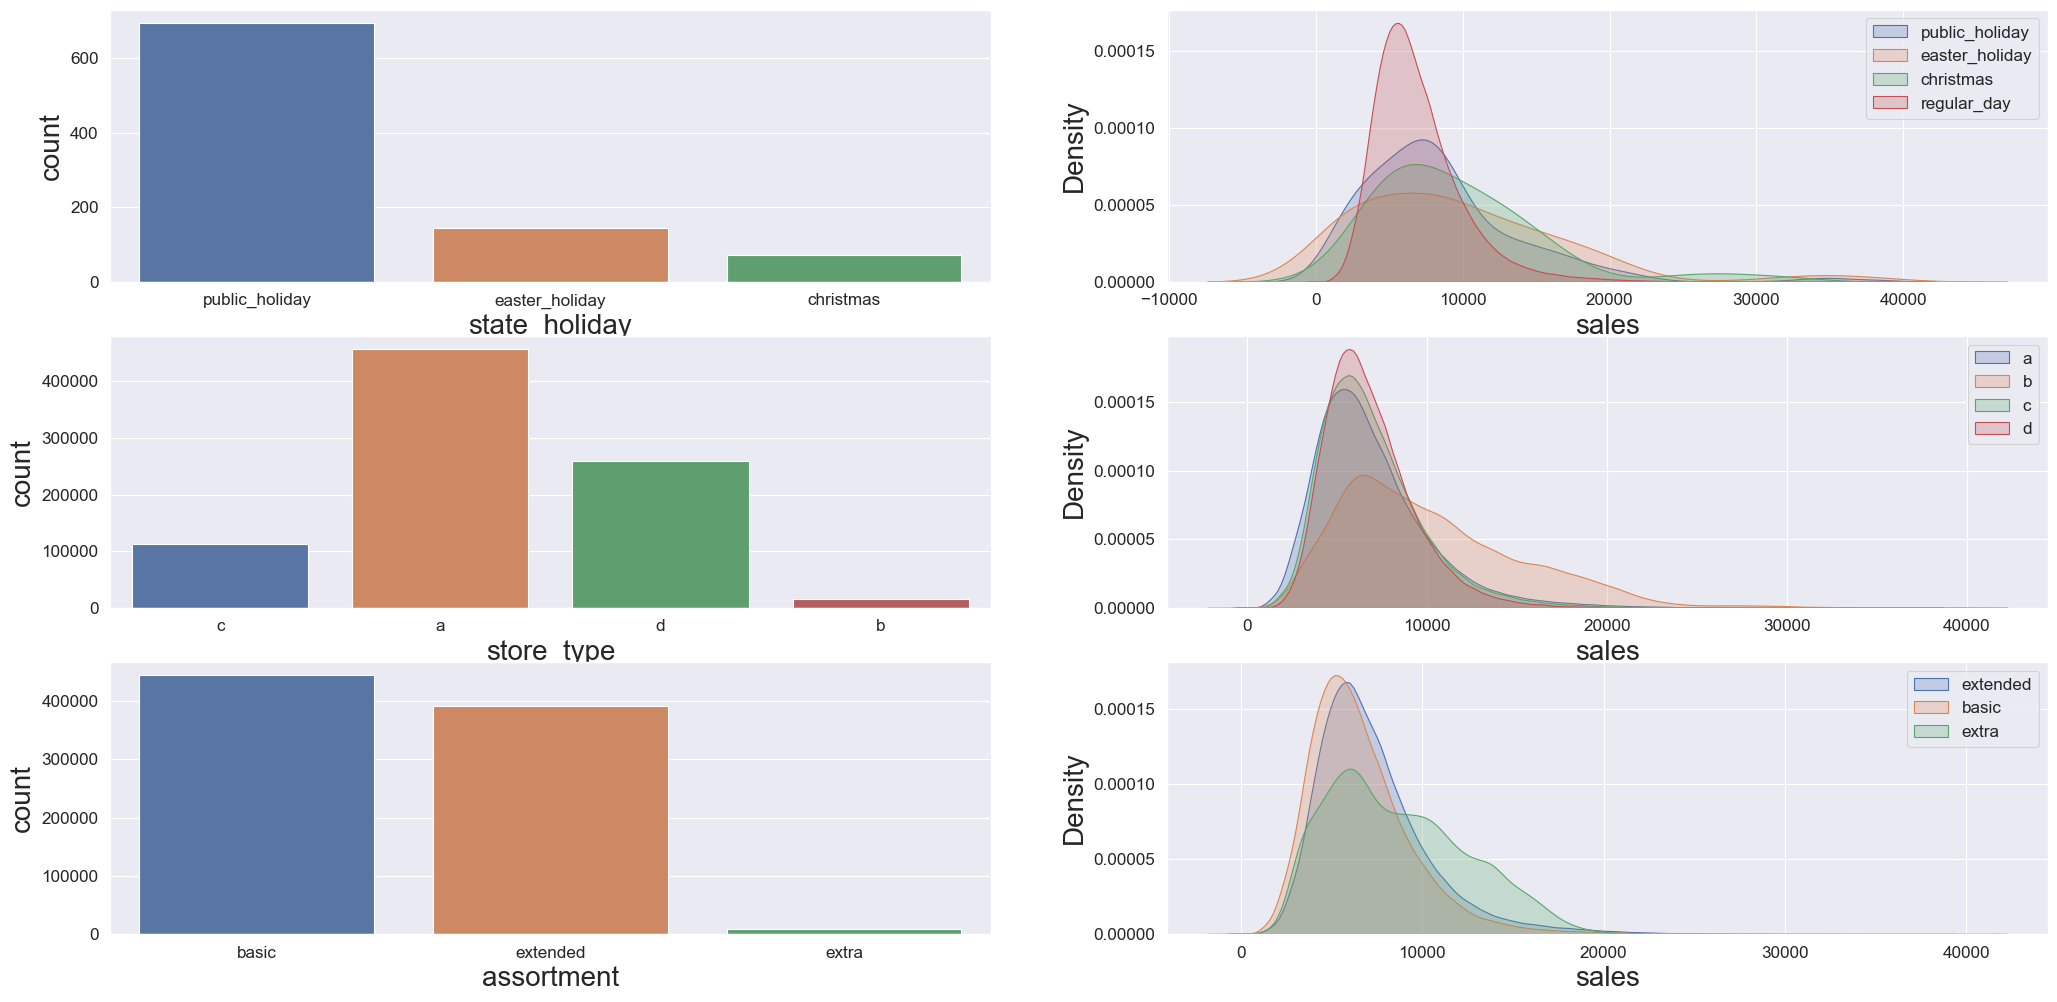

In [38]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'regular_day']['sales'], label = 'regular_day', shade=True)
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(x =df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)
plt.legend()

## 4.2 - Análise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais
**FALSA** - Lojas com MAIOR SORTMENTO vendem MENOS

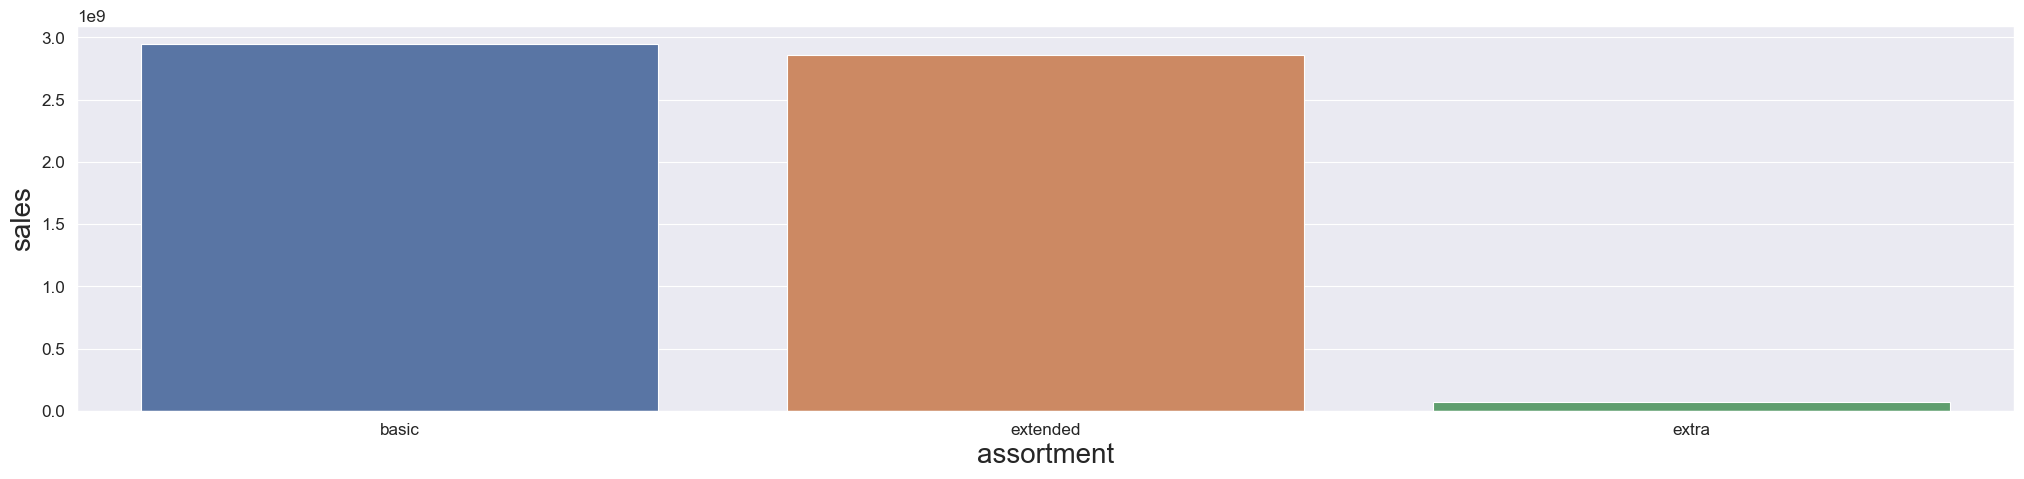

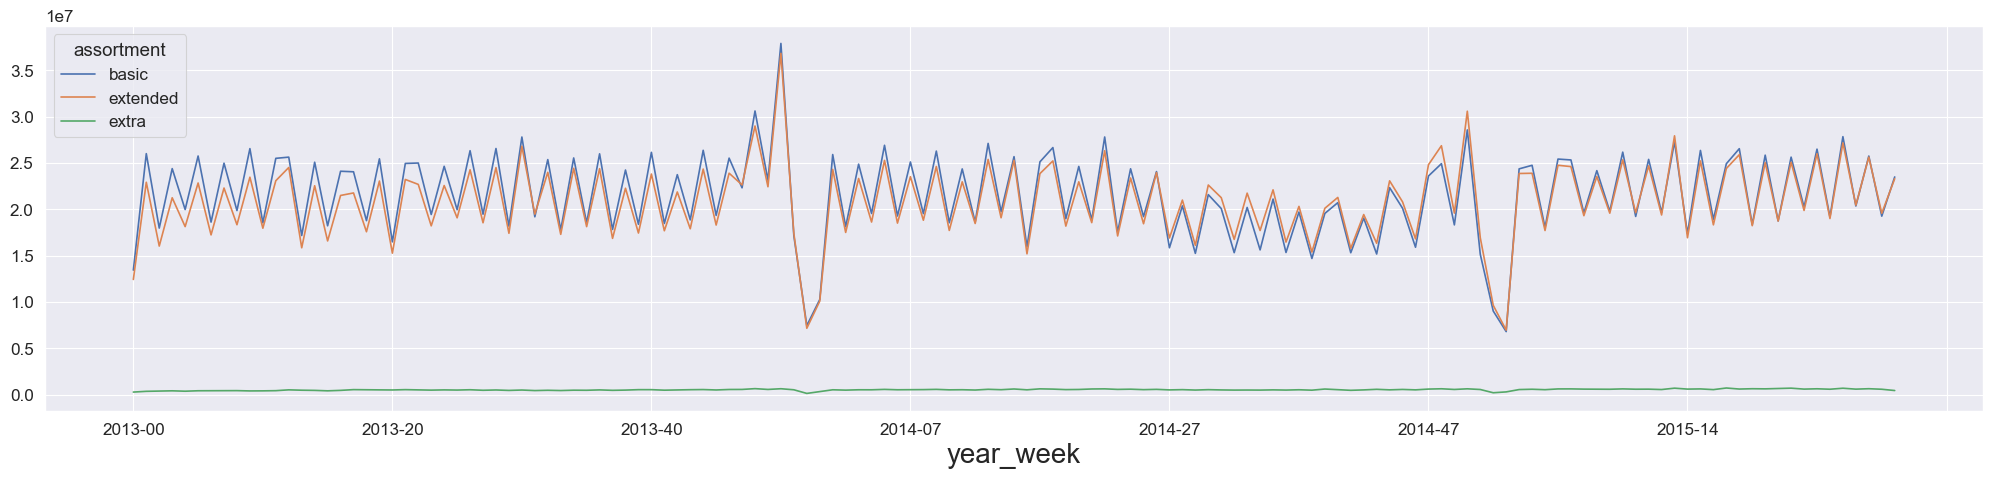

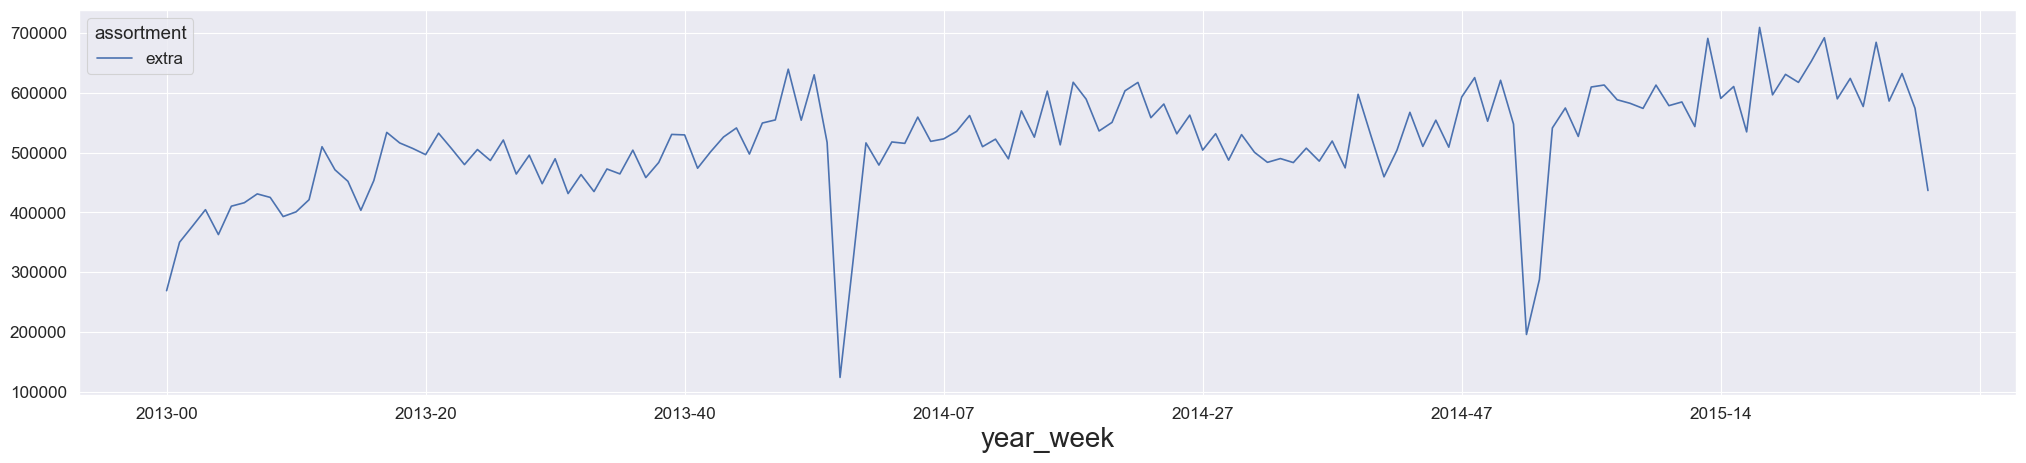

In [39]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#Para observar a variação durante as semanas dos anos para cada um dos assortments
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#Para observar melhor a linha do extra, já que ela estava muito reta antes
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2 - Lojas com competidores mais próximos deveriam vender menos
**FALSA** - Lojas com competidores mais próximos vendem mais

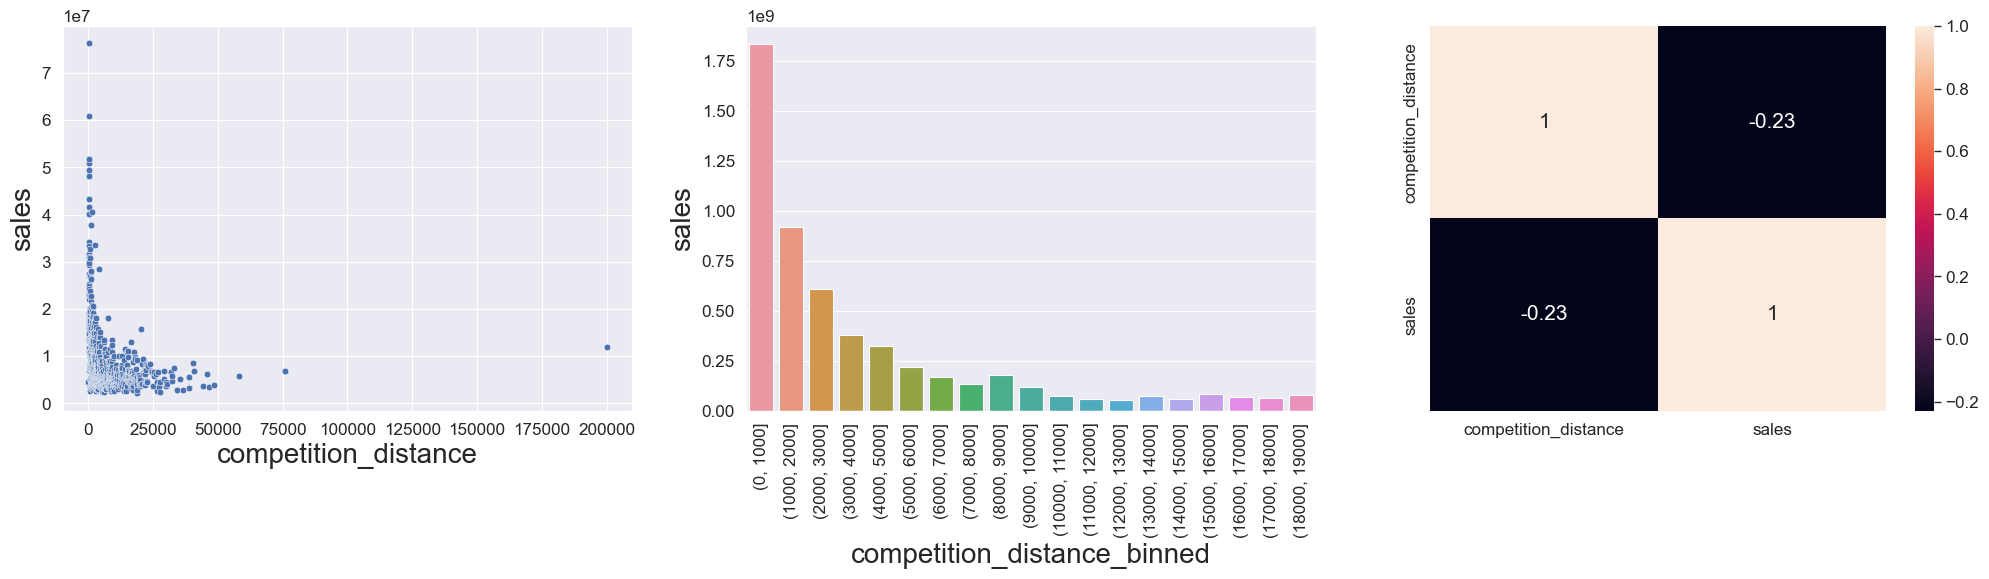

In [40]:
plt.rcParams['figure.figsize'] = [25, 5]
#Como da forma abaixo o gráfico fica muito granular é melhor separar a distancia em grupos, usando o bin
#aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#sns.barplot(x='competition_distance', y='sales', data=aux1);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
plt.xticks(rotation=90)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3 - Lojas com competidores à mais tempo deveriam vender mais
**FALSA** - Lojas com competidores à mais tempo vendem menos

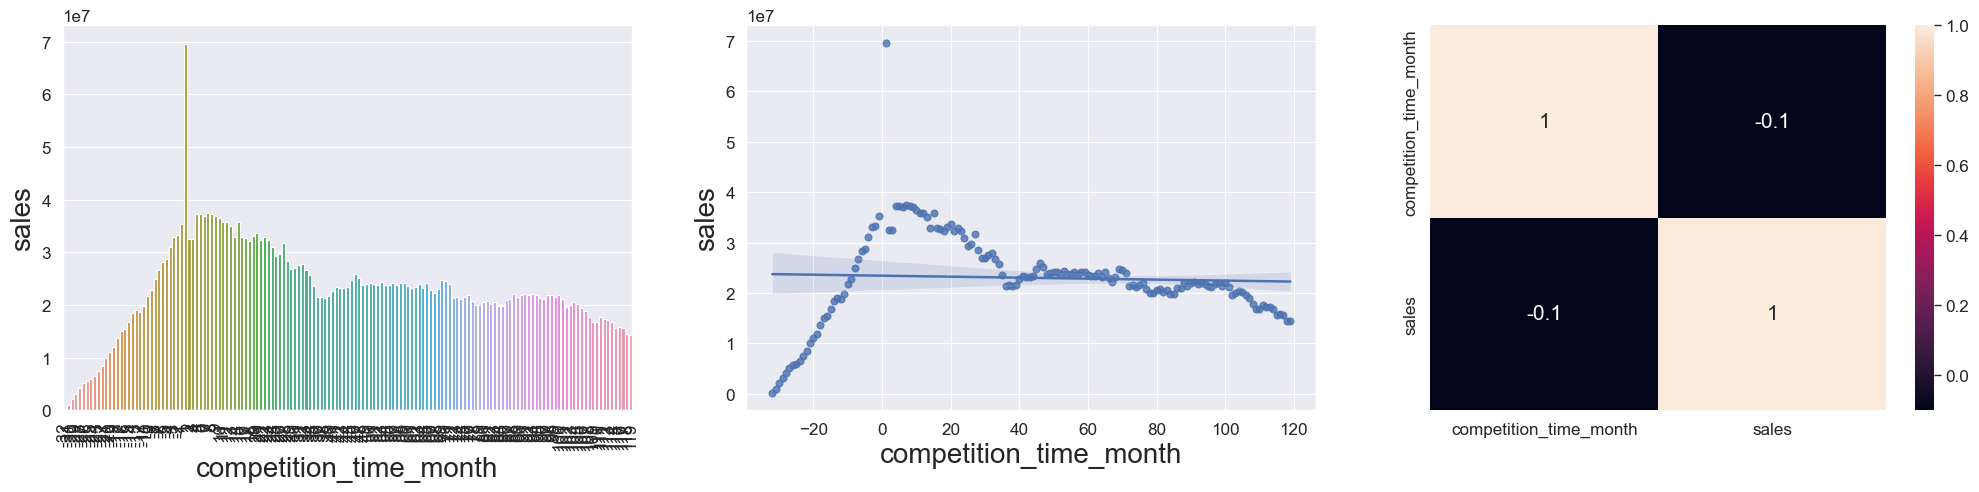

In [41]:
#competition_time_month representa a diferença entre a data observada com o dia q o competidor abriu (a distância entre uma data e a data de abertura do competidor)

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4 - Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

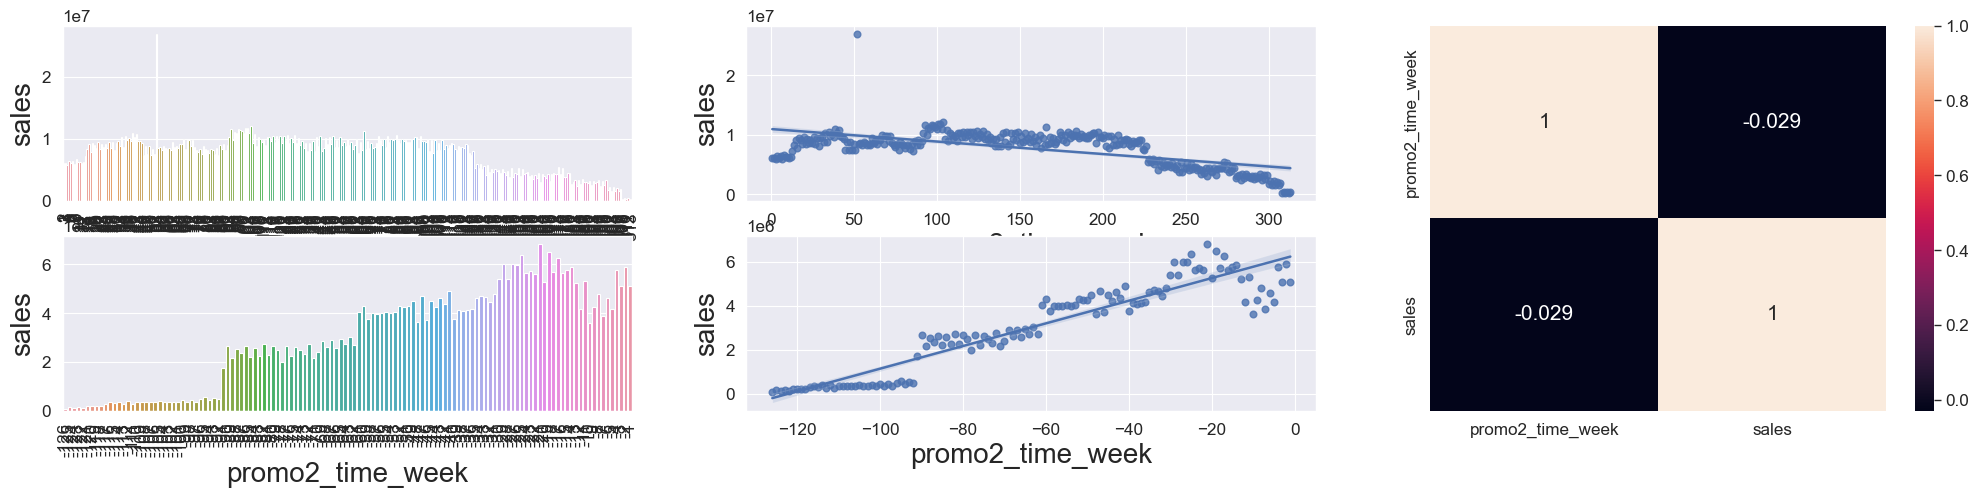

In [42]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['promo2_time_week', 'sales']].groupby('promo2_time_week').sum().reset_index()

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo2_time_week'] > 0] #promo extendido
sns.barplot(x='promo2_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo2_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo2_time_week'] < 0] #promo regular
sns.barplot(x='promo2_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo2_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5 - Lojas que ficam **mais dias com promoção** deveriam **vender mais**</s>

### H6 - Lojas com mais **promoções consecutivas** deveriam **vender mais**
**FALSA** - Lojas com mais promoções consecutivas vendem menos

In [43]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


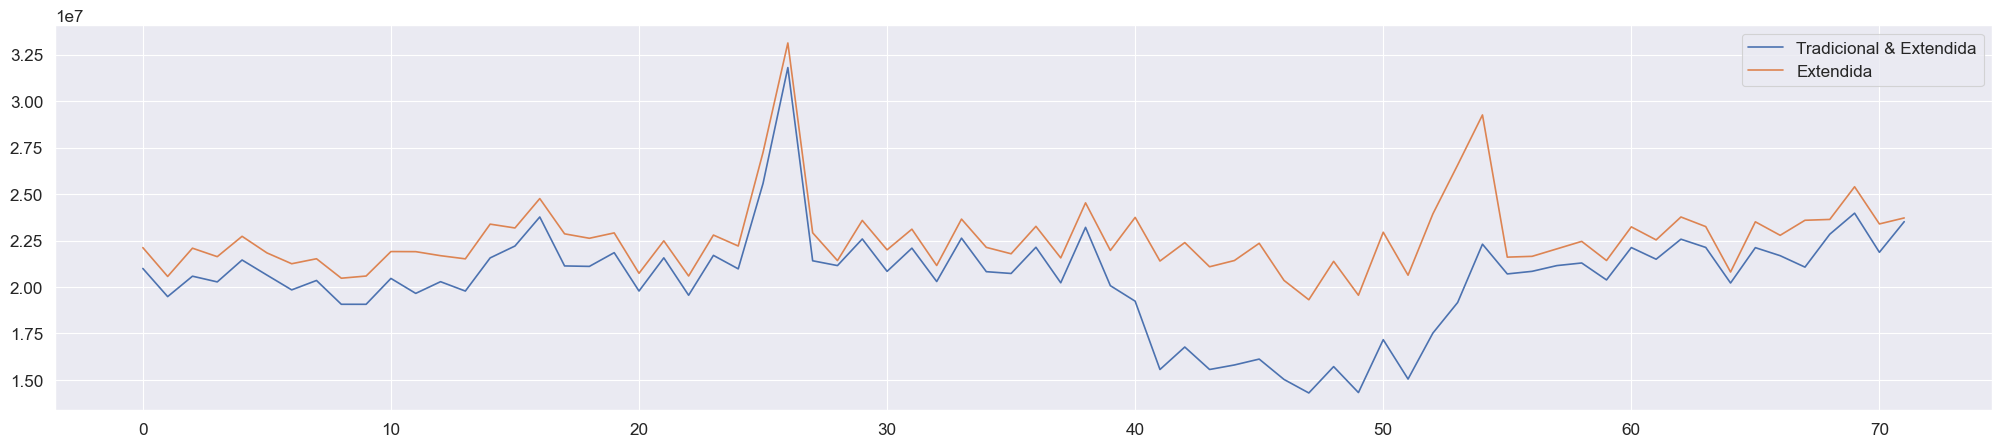

In [44]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7 - Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**
**FALSA** - Lojas abertas durante o feriado do natal vendem menos

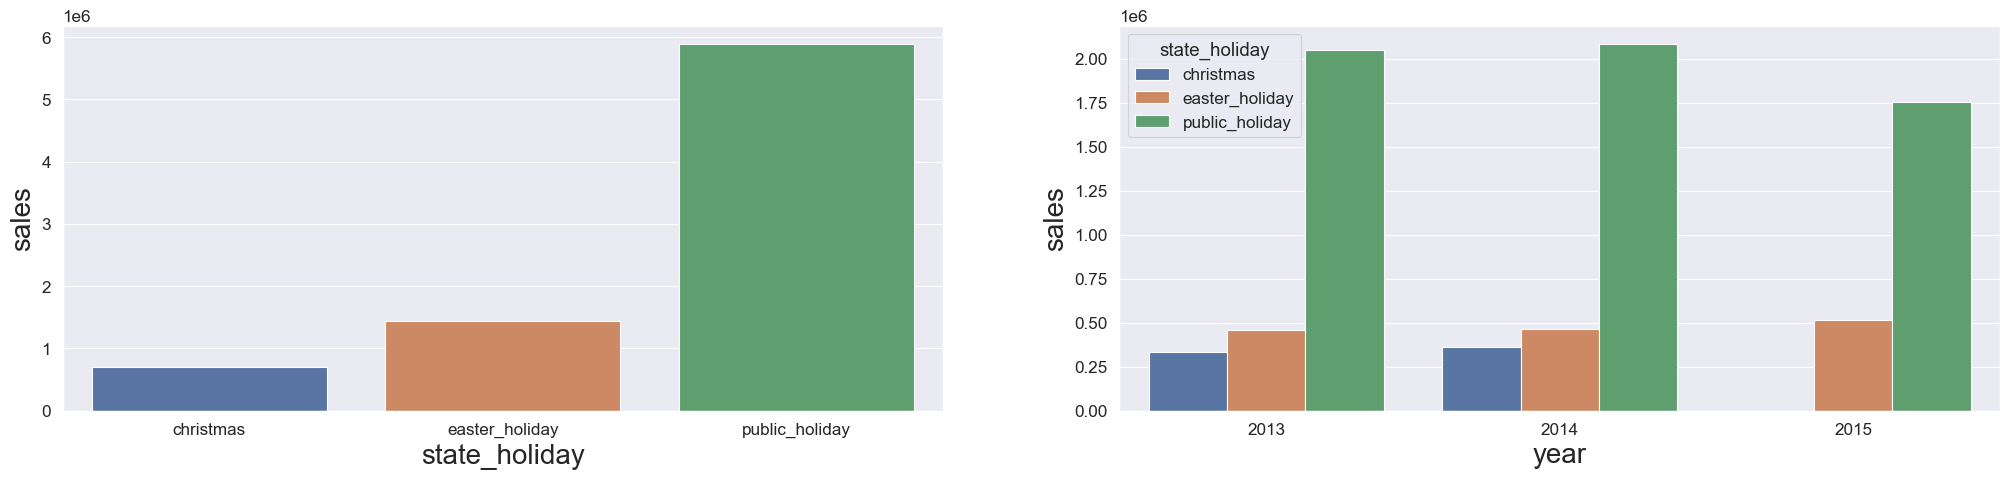

In [45]:
plt.rcParams['figure.figsize'] = [25, 5]
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8 - Lojas deveriam **vender mais** ao **longo dos anos**
**FALSA** - Lojas vendem menos ao longo dos anos

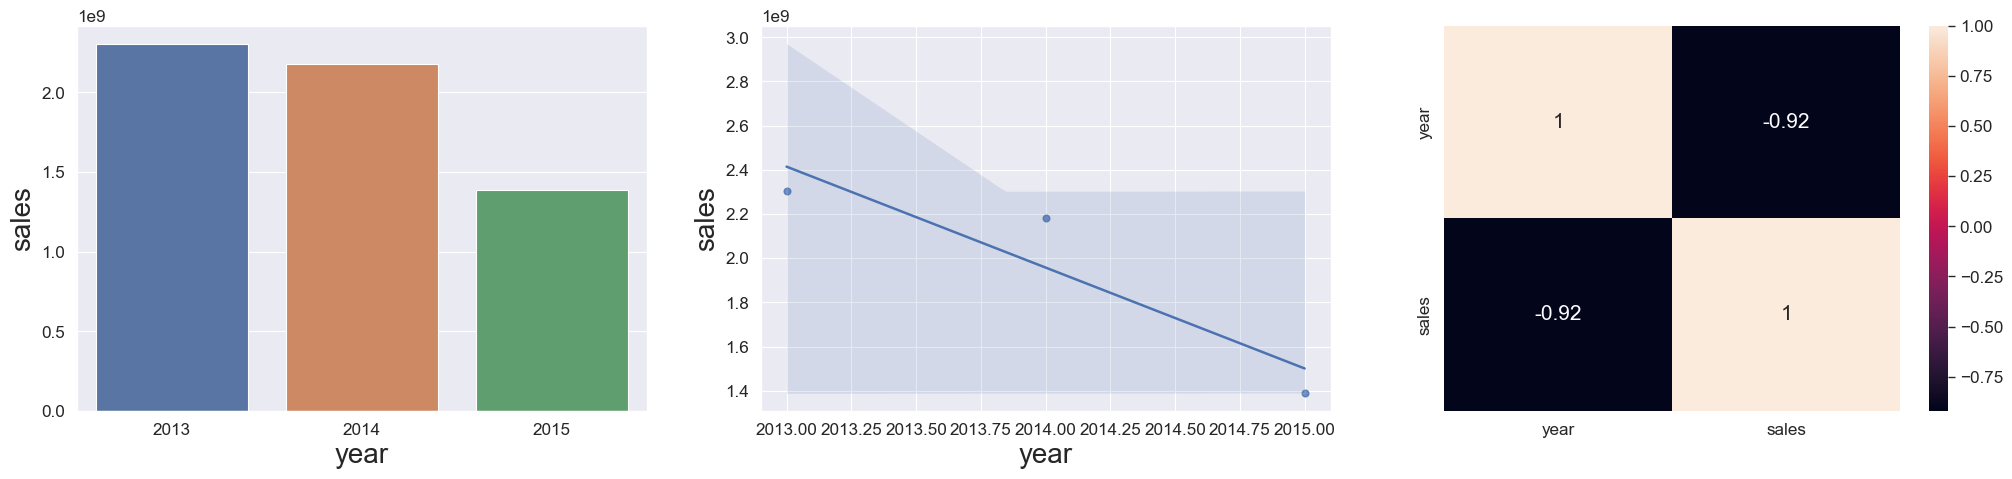

In [46]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 - Lojas deveriam **vender mais** no **segundo semestre** do ano
**FALSA** - Lojas vendem menos no segundo semestre do ano

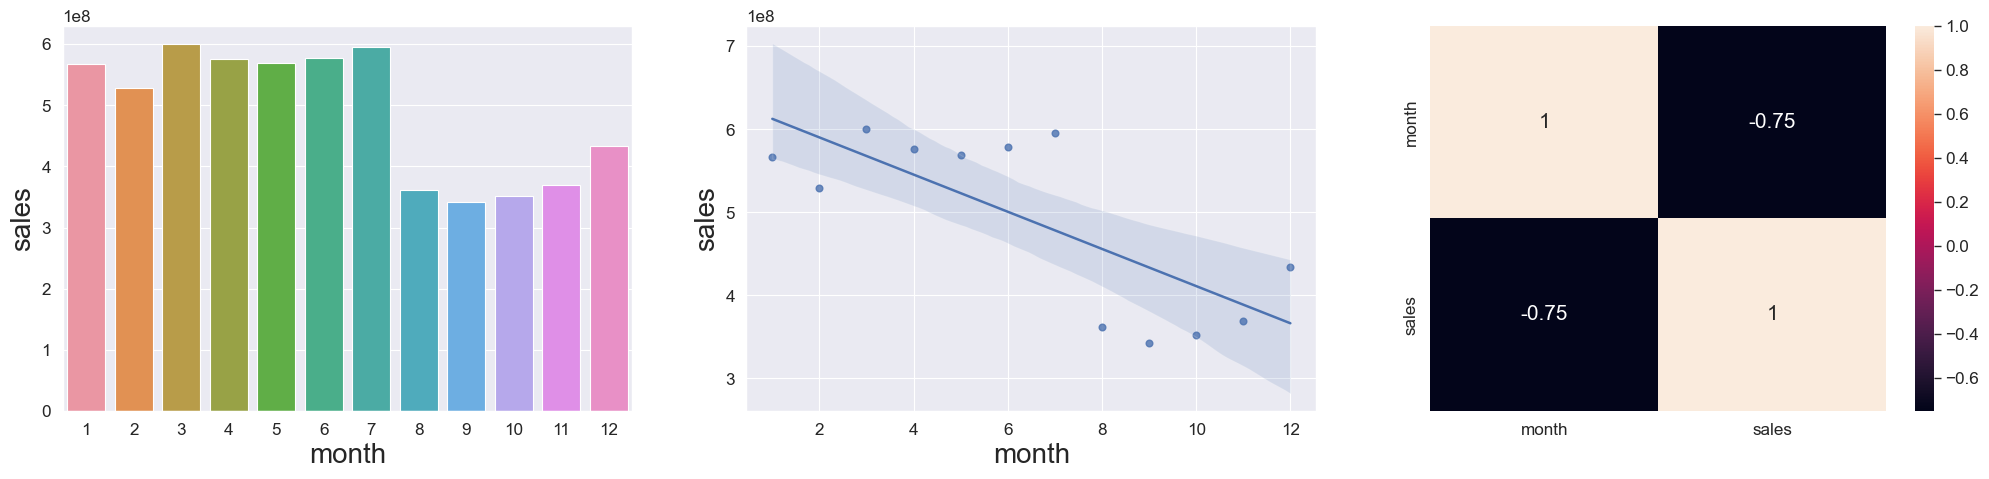

In [47]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10 - Lojas deveriam **vender mais** **depois do dia 10** de cada mês
**VERDADEIRA** - Lojas vendem mais depois do dia 10 de cada mês

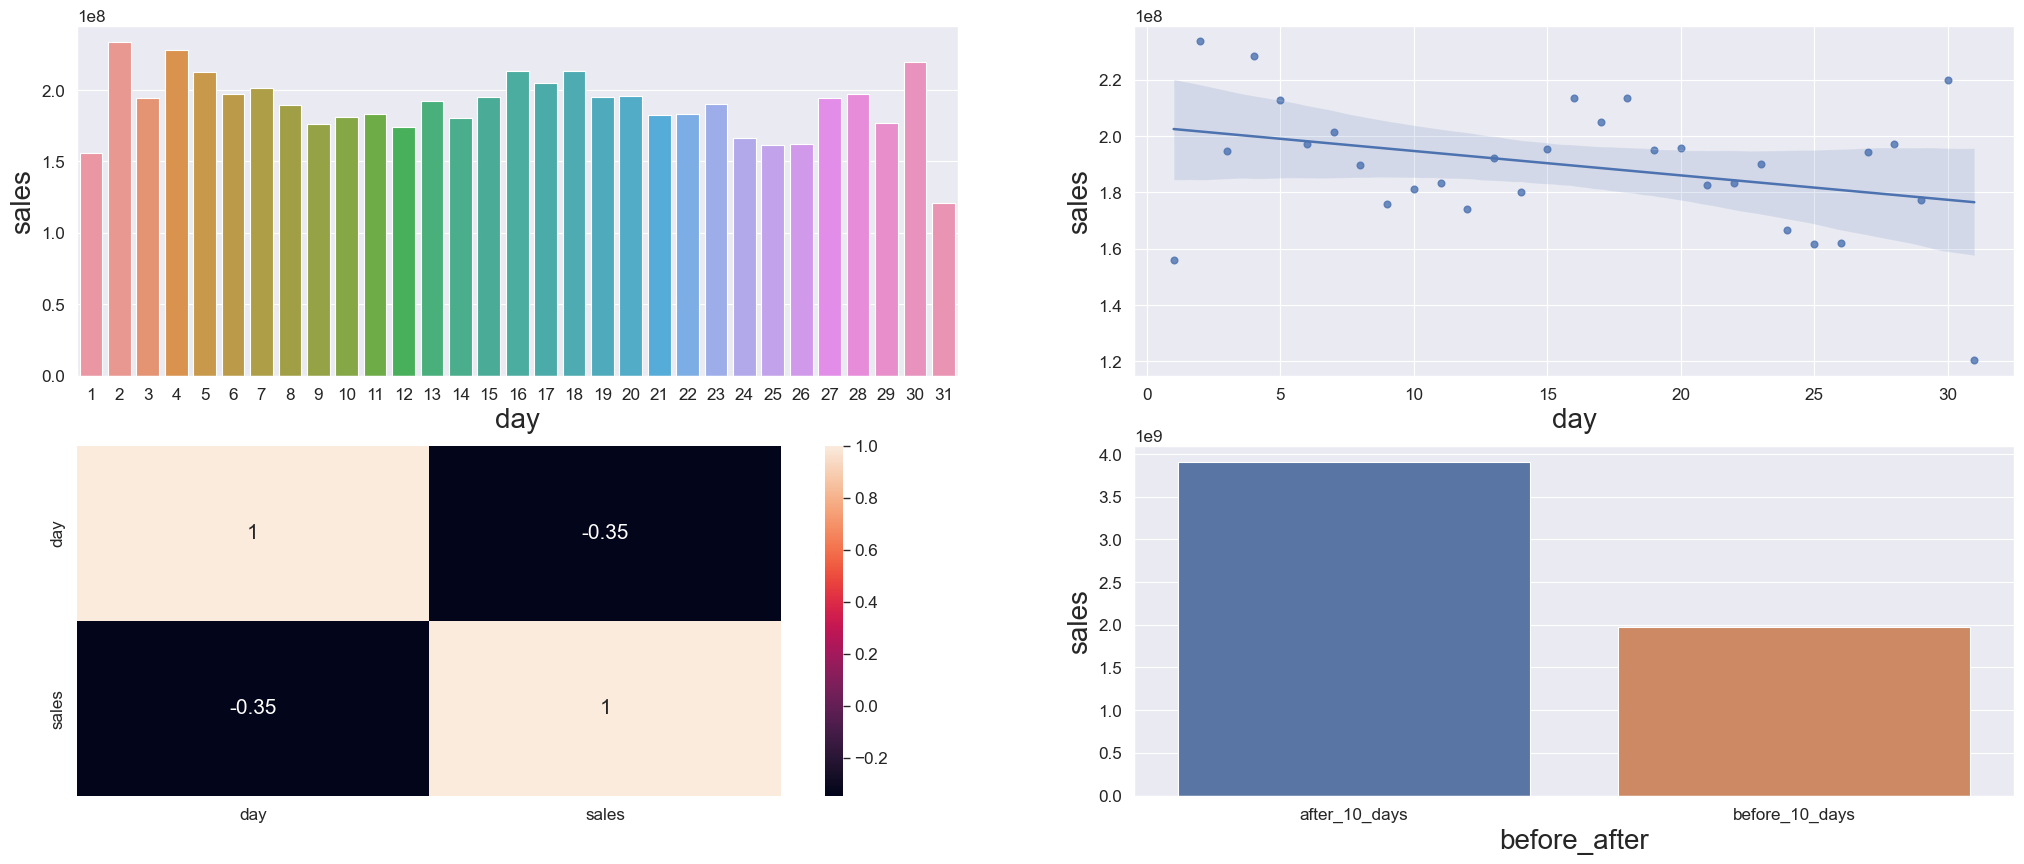

In [48]:
plt.rcParams['figure.figsize'] = [25, 10]
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11 - Lojas deveriam **vender menos** aos **finais de semana**
**VERDADEIRA** - Lojas vendem menos nos finais de semana

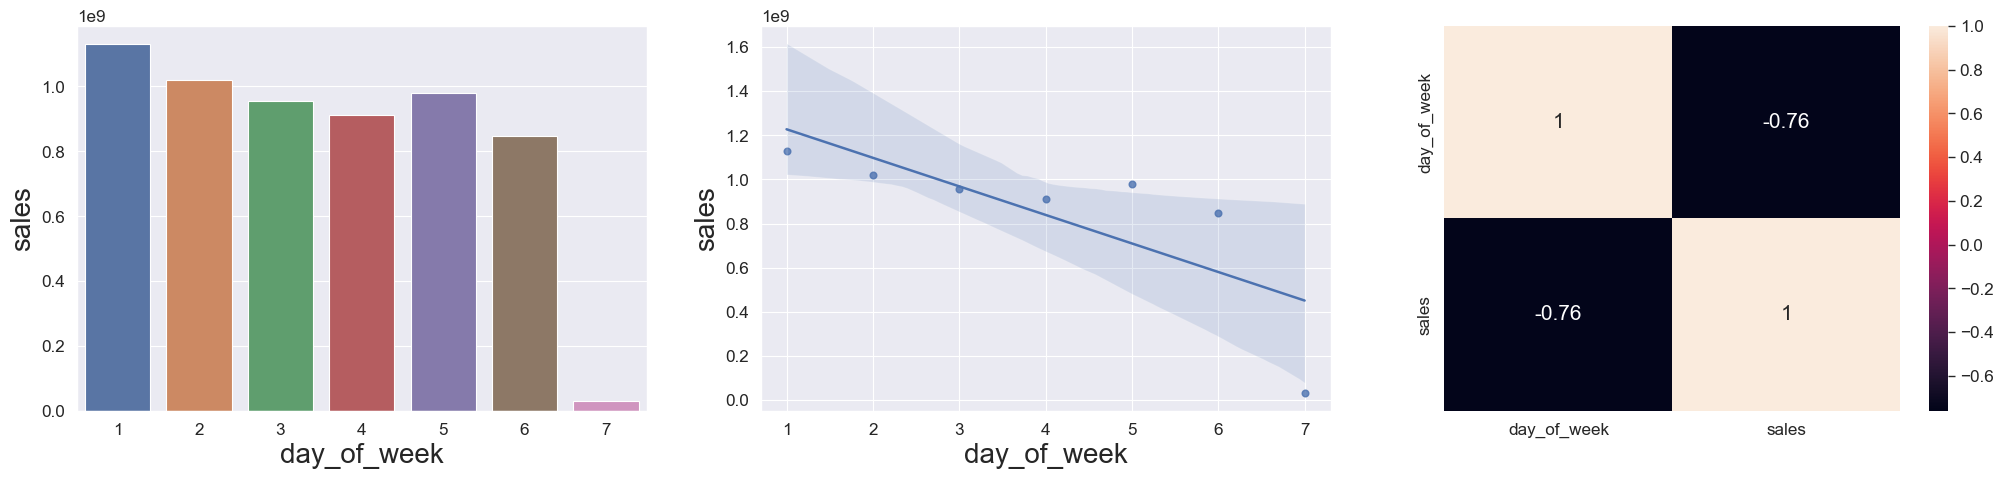

In [49]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 - Lojas deveriam **vender menos** durante os **feriados escolares**
**VERDADERIA** - Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto

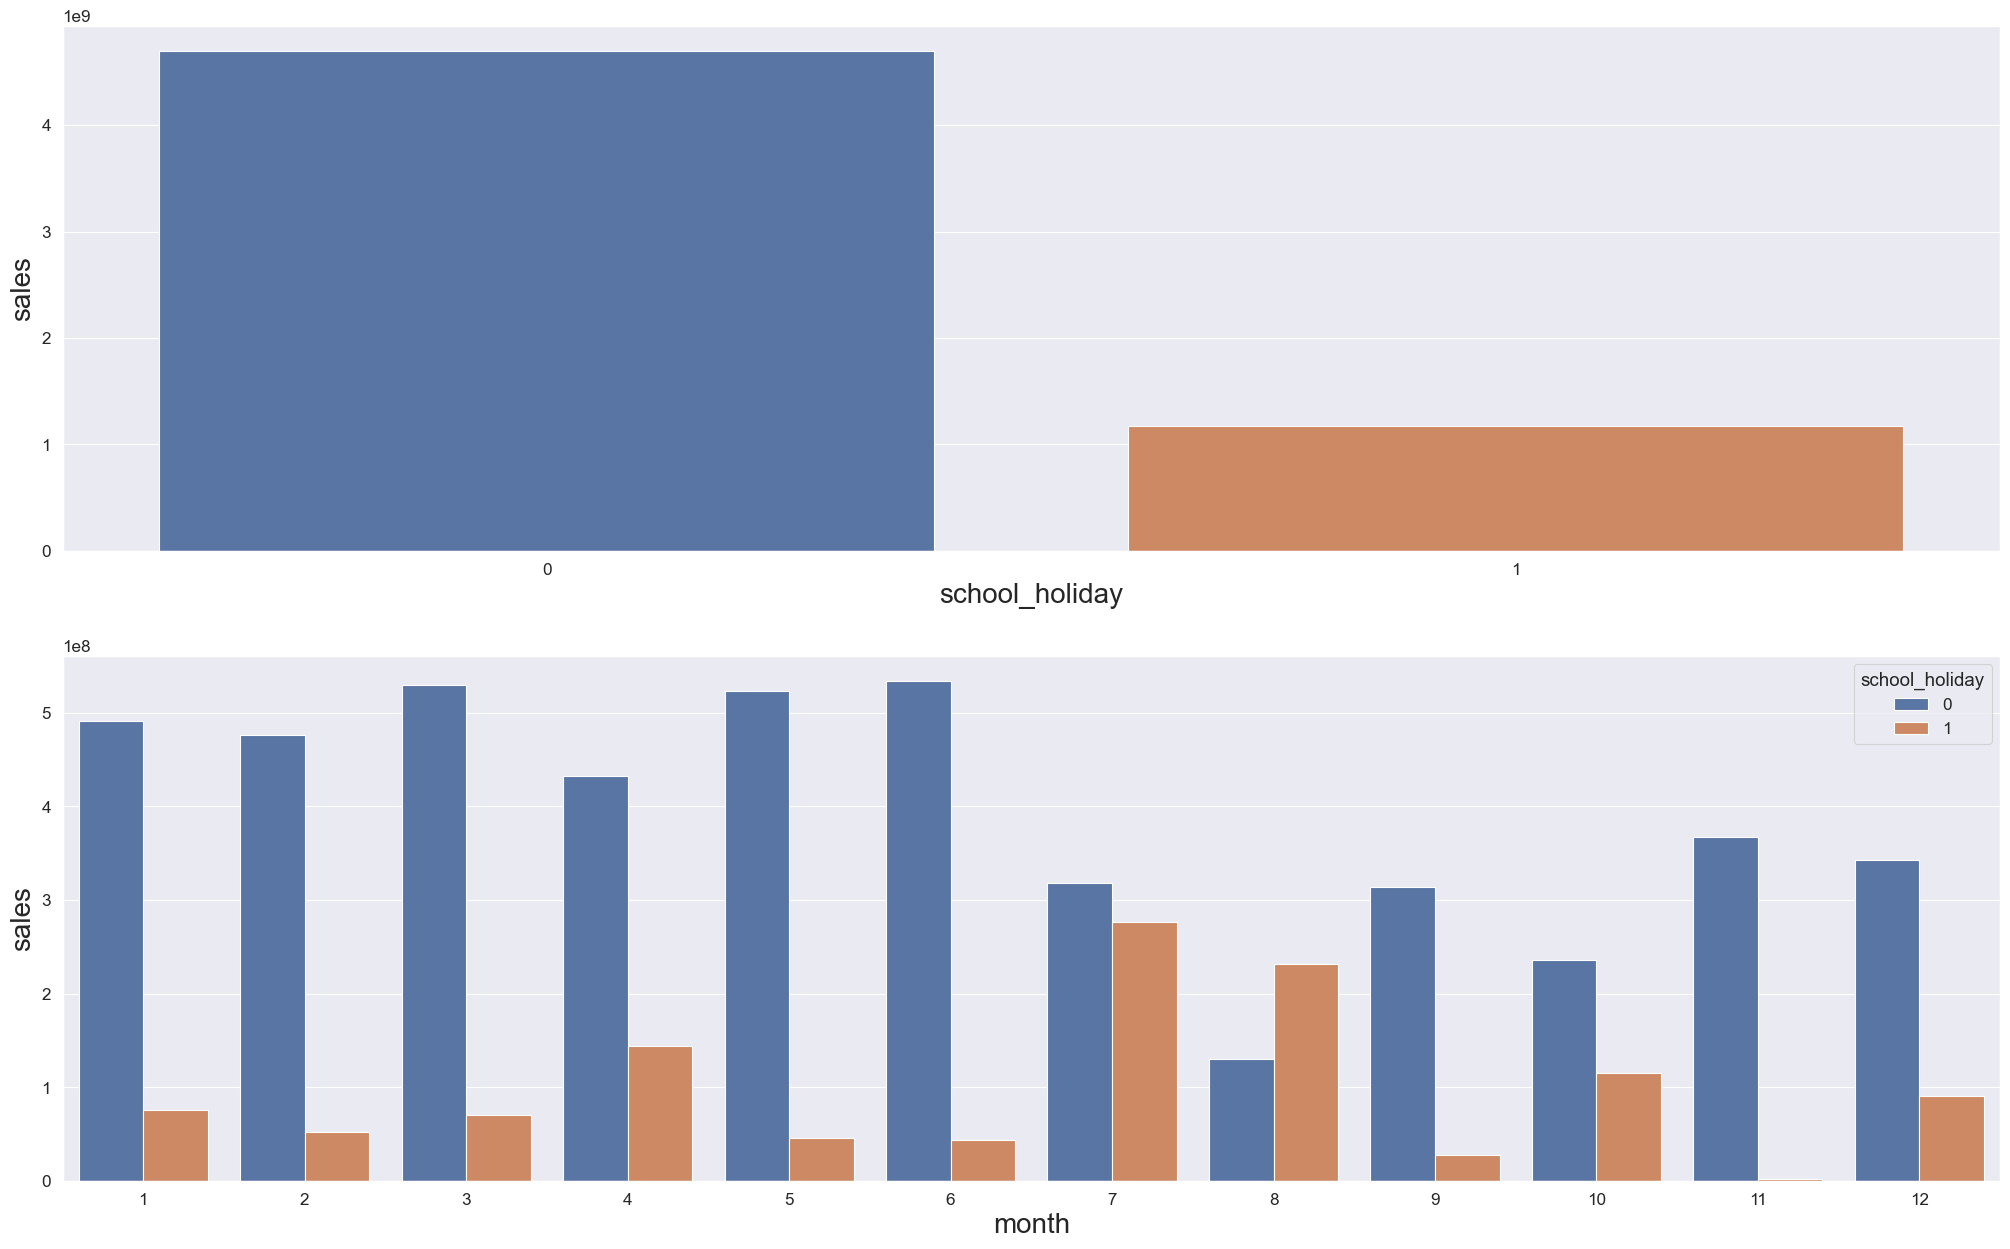

In [50]:
plt.rcParams['figure.figsize'] = [25, 15]

plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 - Resumo das Hipóteses

In [51]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada

### 4.3.1 - Numerical Attributes

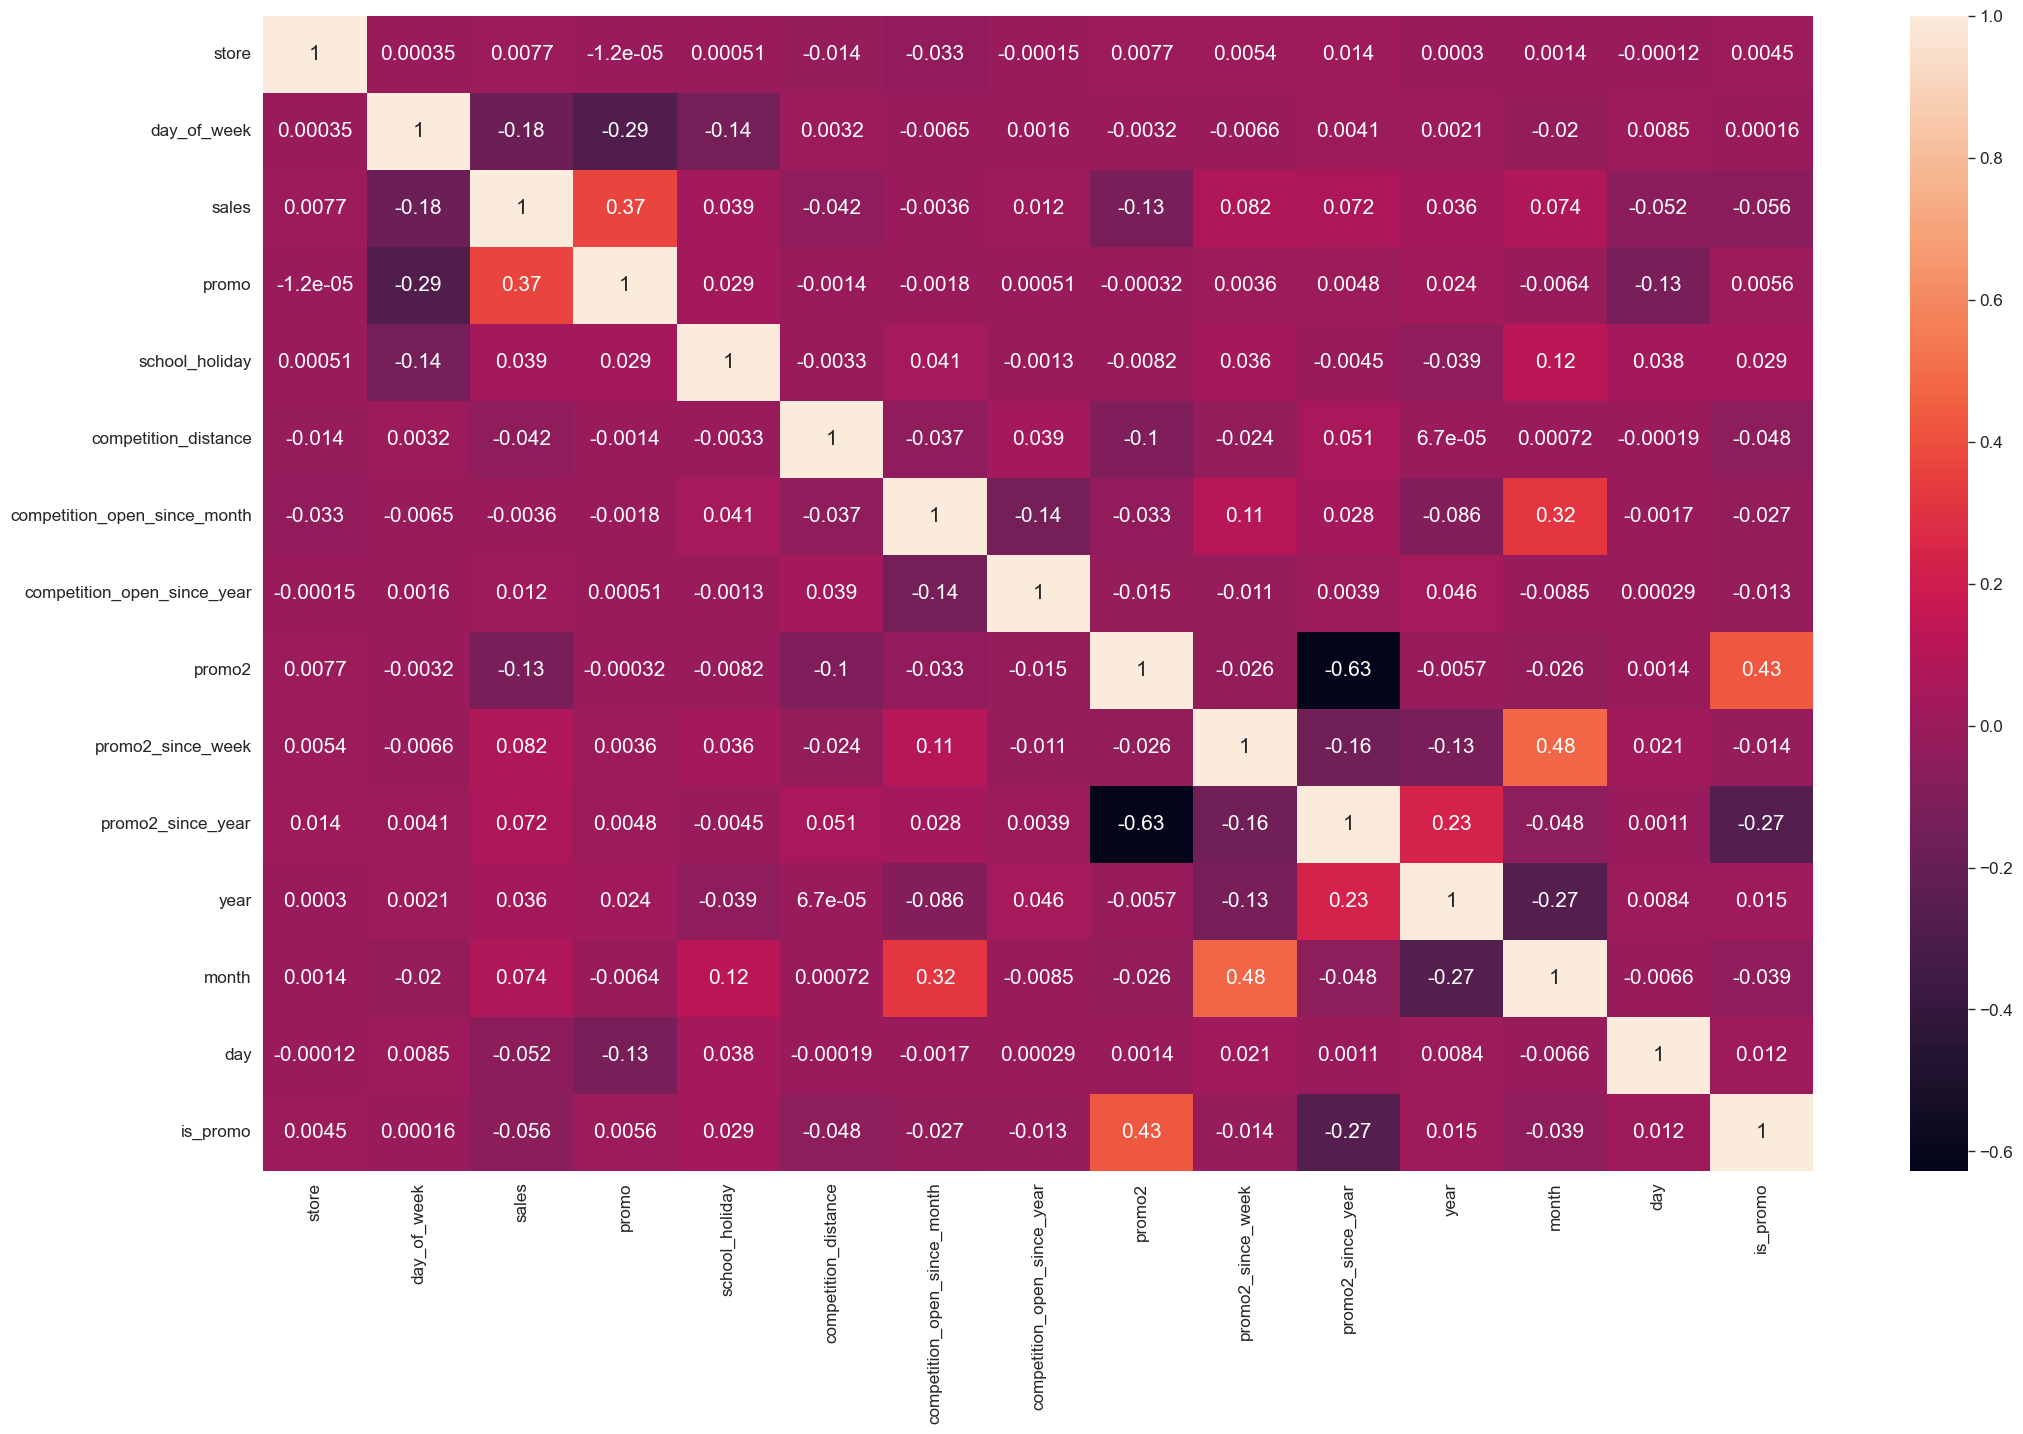

In [52]:
correlation = num_attributes2.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Categorical Attributes

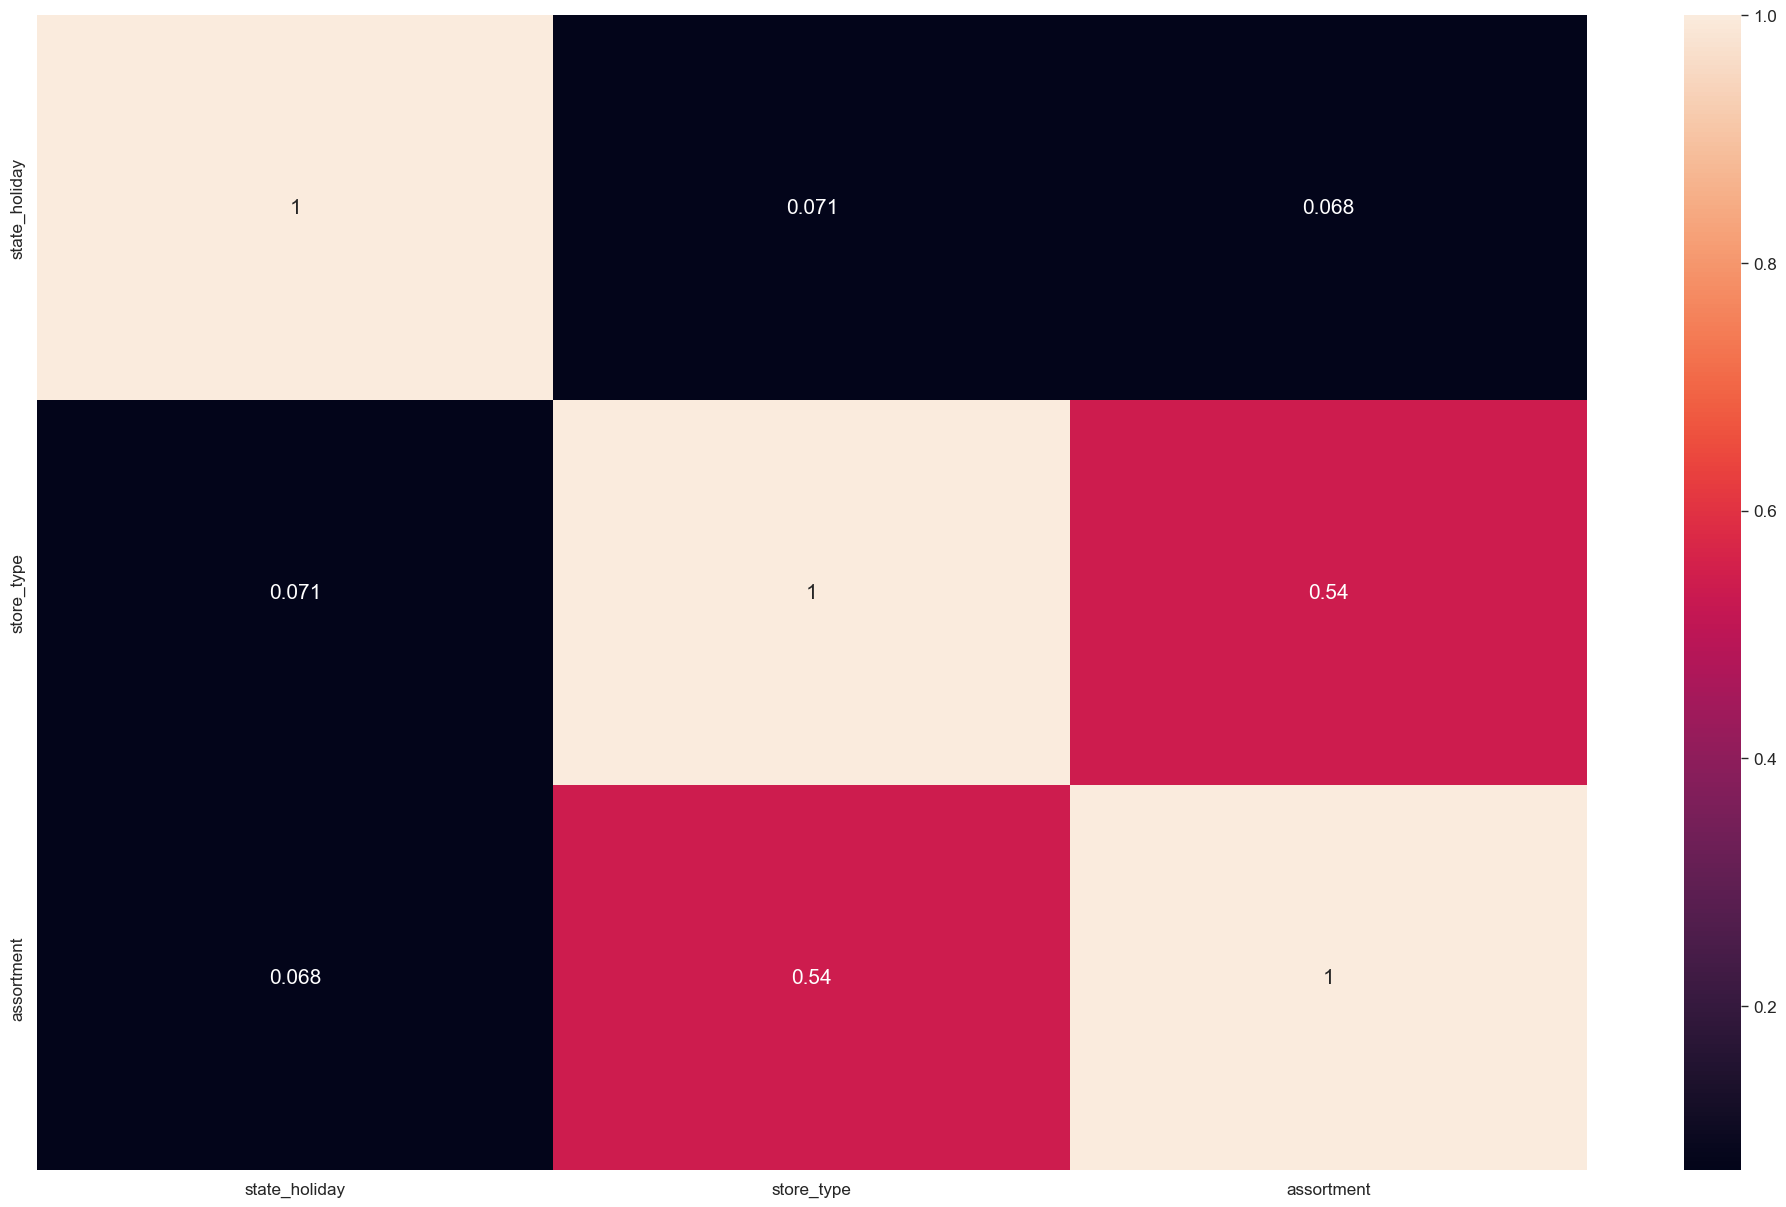

In [53]:
#only categorical data
a = df4.select_dtypes(include='object')

#Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 - PASSO 05 - Data Preparation

In [54]:
df5 = df4.copy()

## 5.1 - Normalizacao

- Como nenhuma feature possui uma distribuição normal (Gaussiana) não será aplicada a técnica de normalização nas features

## 5.2 - Rescaling

### 5.2.1 - Features com bastante outliers

In [55]:
rs = RobustScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\competition_time_month_scaler.pkl', 'wb'))

### 5.2.2 - Features com poucos ou nenhum outliers

In [56]:
mms = MinMaxScaler()

#promo time week
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values)
pickle.dump(rs, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\year_scaler.pkl', 'wb'))

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [57]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\store_type_scaler.pkl', 'wb'))

#assortment
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 - Response Variable Transformation

In [58]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 - Nature Transformation

In [59]:
#day of week
df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))
#month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sen'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week of year
df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

# 6.0 - PASSO 06 - Feature Selection

In [60]:
df6 = df5.copy()

## 6.1 - Split dataframe in training and test dataset

In [61]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [62]:
#Identificar a data correspondente a 6 semanas antes da última data
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [63]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Traning Min Date: {}'.format(X_train['date'].min()))
print('Traning Min Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Traning Min Date: 2013-01-01 00:00:00
Traning Min Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [64]:
# #training and test dataset for boruta
# X_train_n = X_train.drop(['sales', 'date'], axis=1).values
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# #define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 - Best Fratures from Boruta

In [65]:
# cols_selected = boruta.support_.tolist()

# #best features
# X_train_fs = X_train.drop(['sales', 'date'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

In [ ]:
# #Boruta - features (Selecionados)
# cols_selected_boruta

In [ ]:
# #Boruta - features (Não selecionados)
# cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [71]:
#Selecionar manualmente as features selecionadas da análise exploratória e do Boruta - COMENTAR O ITEM 6.2 PARA NÃO RODAR OUTRA VEZ JUNTO COM O RESTANTE DO CÓDIGO
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo2_time_week',
     'day_of_week_sen',
     'day_of_week_cos',
     'month_cos',
     'day_sen',
     'day_cos',
     'week_of_year_cos']

#columns add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 - PASSO 07 - Machine Learning Modelling

In [72]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 - Average Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression Model

In [75]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.547959,0.294767,2667.917566


### 7.2.1 - Linear Regression Model - Cross Validation

In [76]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2079.3+/-303.27,0.3+/-0.01,2961.78+/-473.37


## 7.3 - Linear Regression Regularized Model - Lasso

In [77]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.547959,0.294767,2667.917566


### 7.3 - Linear Regression Regularized Model - Lasso - Cross Validation

In [78]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Lasso,2117.48+/-342.2,0.29+/-0.01,3060.6+/-504.54


## 7.4 - Random Forest Regressor

In [79]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)## 7.4 - Random Forest Regressor

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,740.373195,0.110192,1096.171655


### 7.4.1 - Random Forest Regressor - Cross Validation

In [82]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,845.27+/-223.07,0.12+/-0.02,1265.98+/-323.98


## 7.5 - XGBoost Regressor

In [81]:
#model
model_xgb = xbg.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,865.243861,0.126647,1256.658785


### 7.5.1 - XGBoost Regressor - Cross Validation

In [85]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1105.76+/-230.11,0.15+/-0.02,1644.56+/-420.36


## 7.6 - Compare Models's Performance

### 7.6.1 - Single Performance

In [83]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,740.373195,0.110192,1096.171655
0,XGBoost Regressor,865.243861,0.126647,1256.658785
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.547959,0.294767,2667.917566
0,Linear Regression - Lasso,1869.547959,0.294767,2667.917566


### 7.6.2 - Real Performance - Cross Validation

In [86]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,845.27+/-223.07,0.12+/-0.02,1265.98+/-323.98
0,XGBoost Regressor,1105.76+/-230.11,0.15+/-0.02,1644.56+/-420.36
0,Linear Regression,2079.3+/-303.27,0.3+/-0.01,2961.78+/-473.37
0,Lasso,2117.48+/-342.2,0.29+/-0.01,3060.6+/-504.54


# 8.0 - PASSO 08 - Hyperparameter Fine Tuning

## 8.1 - Random Search

In [95]:
# param= {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytree': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [96]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)
   
#     #model
#     model_xgb = xbg.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

   
#     #performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])

# final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1054.15+/-284.15,0.14+/-0.04,1507.61+/-395.78
0,XGBoost Regressor,1160.09+/-133.32,0.16+/-0.01,1643.74+/-174.4
0,XGBoost Regressor,914.4+/-124.94,0.13+/-0.01,1304.78+/-194.18
0,XGBoost Regressor,1118.8+/-136.51,0.16+/-0.01,1595.12+/-181.1
0,XGBoost Regressor,1146.27+/-266.22,0.16+/-0.03,1714.57+/-311.49


## 8.2 - Final Model

In [97]:
param_tuned= {'n_estimators': 1500,
        'eta': 0.01,
        'max_depth': 9,
        'subsample': 0.5,
        'colsample_bytree': 0.3,
        'min_child_weight': 3 
        }

In [98]:
#model
model_xgb_tuned = xbg.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=param_tuned['n_estimators'], 
                             eta=param_tuned['eta'], 
                             max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], 
                             colsample_bytree=param_tuned['colsample_bytree'], 
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)


#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,717.852854,0.105248,1031.371473


In [100]:
#Se o reultado do MPE da NEGATIVO está SUPERestimando
#Se o reultado do MPE da POSITIVO está SUBestimando
mpe = mean_percentage_error_2(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.0026021434890964187

# 9.0 - PASSO 09 - Tradução e interpretação do erro

In [112]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\galves\AppData\Local\Temp\ipykernel_14732\403577207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\galves\AppData\Local\Temp\ipykernel_14732\403577207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 - Business Performance

In [120]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenearios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] - df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']]

In [121]:
df92.head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
0,1,159210.921875,158870.598369,158870.598369,340.323506,0.078664
1,2,177572.671875,177203.918035,177203.918035,368.753840,0.078207
2,3,276154.375000,275369.698645,275369.698645,784.676355,0.112970
3,4,353415.875000,352476.291385,352476.291385,939.583615,0.090975
4,5,170997.937500,170624.244853,170624.244853,373.692647,0.087606


<AxesSubplot: xlabel='store', ylabel='MAPE'>

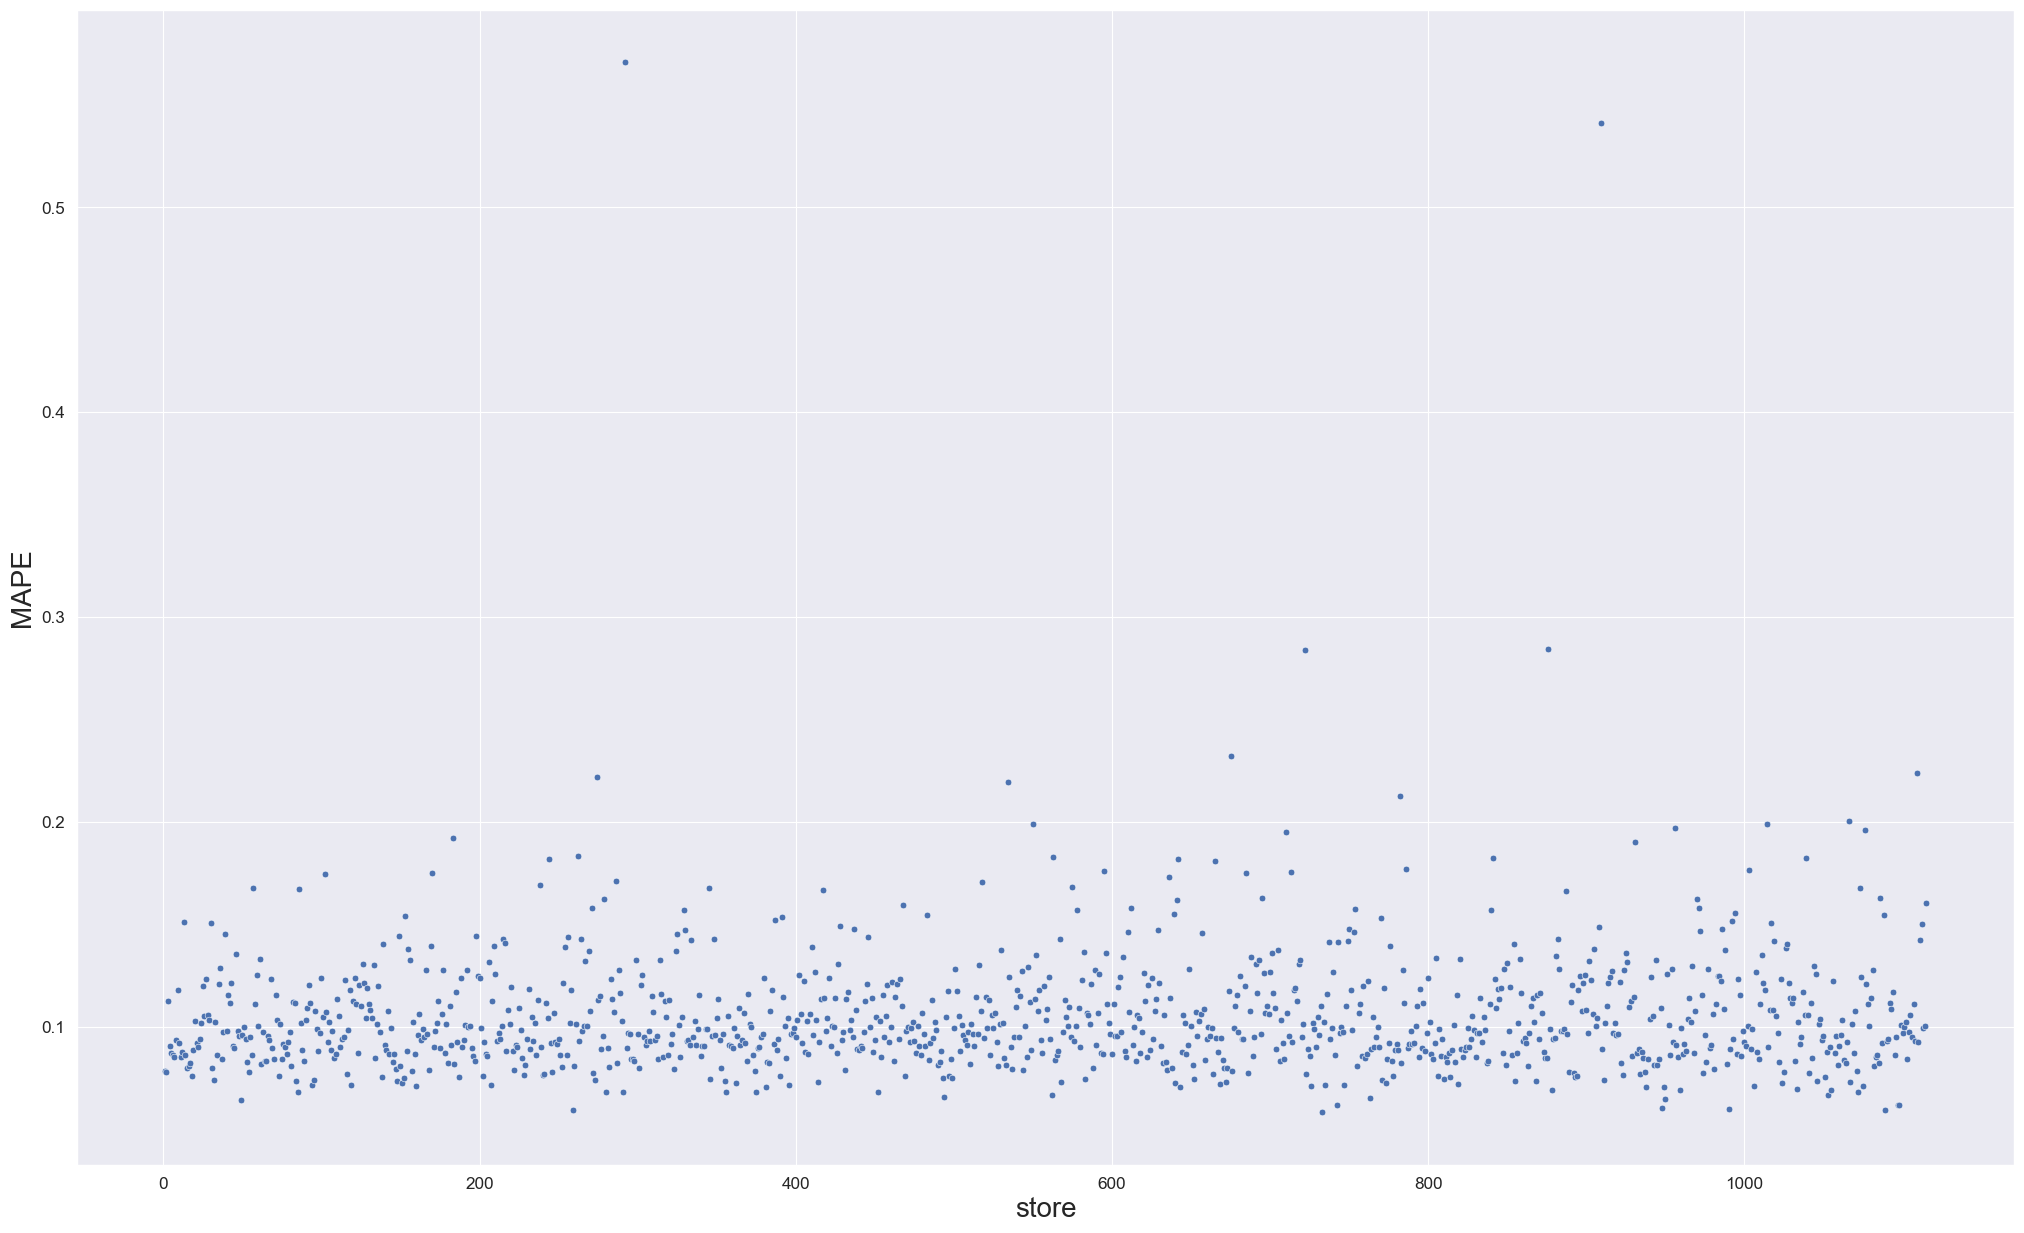

In [104]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 - Total Performance

In [111]:
df93 = df92[['predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$ 286,041,792.00"
1,worst_scenarios,"R$ 285,237,639.60"
2,best_scenarios,"R$ 285,237,639.60"
3,MAE,"R$ 804,126.18"
4,MAPE,R$ 117.81


## 9.3 - Machine Learning Performance

In [122]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\galves\AppData\Local\Temp\ipykernel_14732\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\galves\AppData\Local\Temp\ipykernel_14732\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\galves\AppData\Local\Temp\ipykernel_14732\2082100954.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df9['error_rate'])


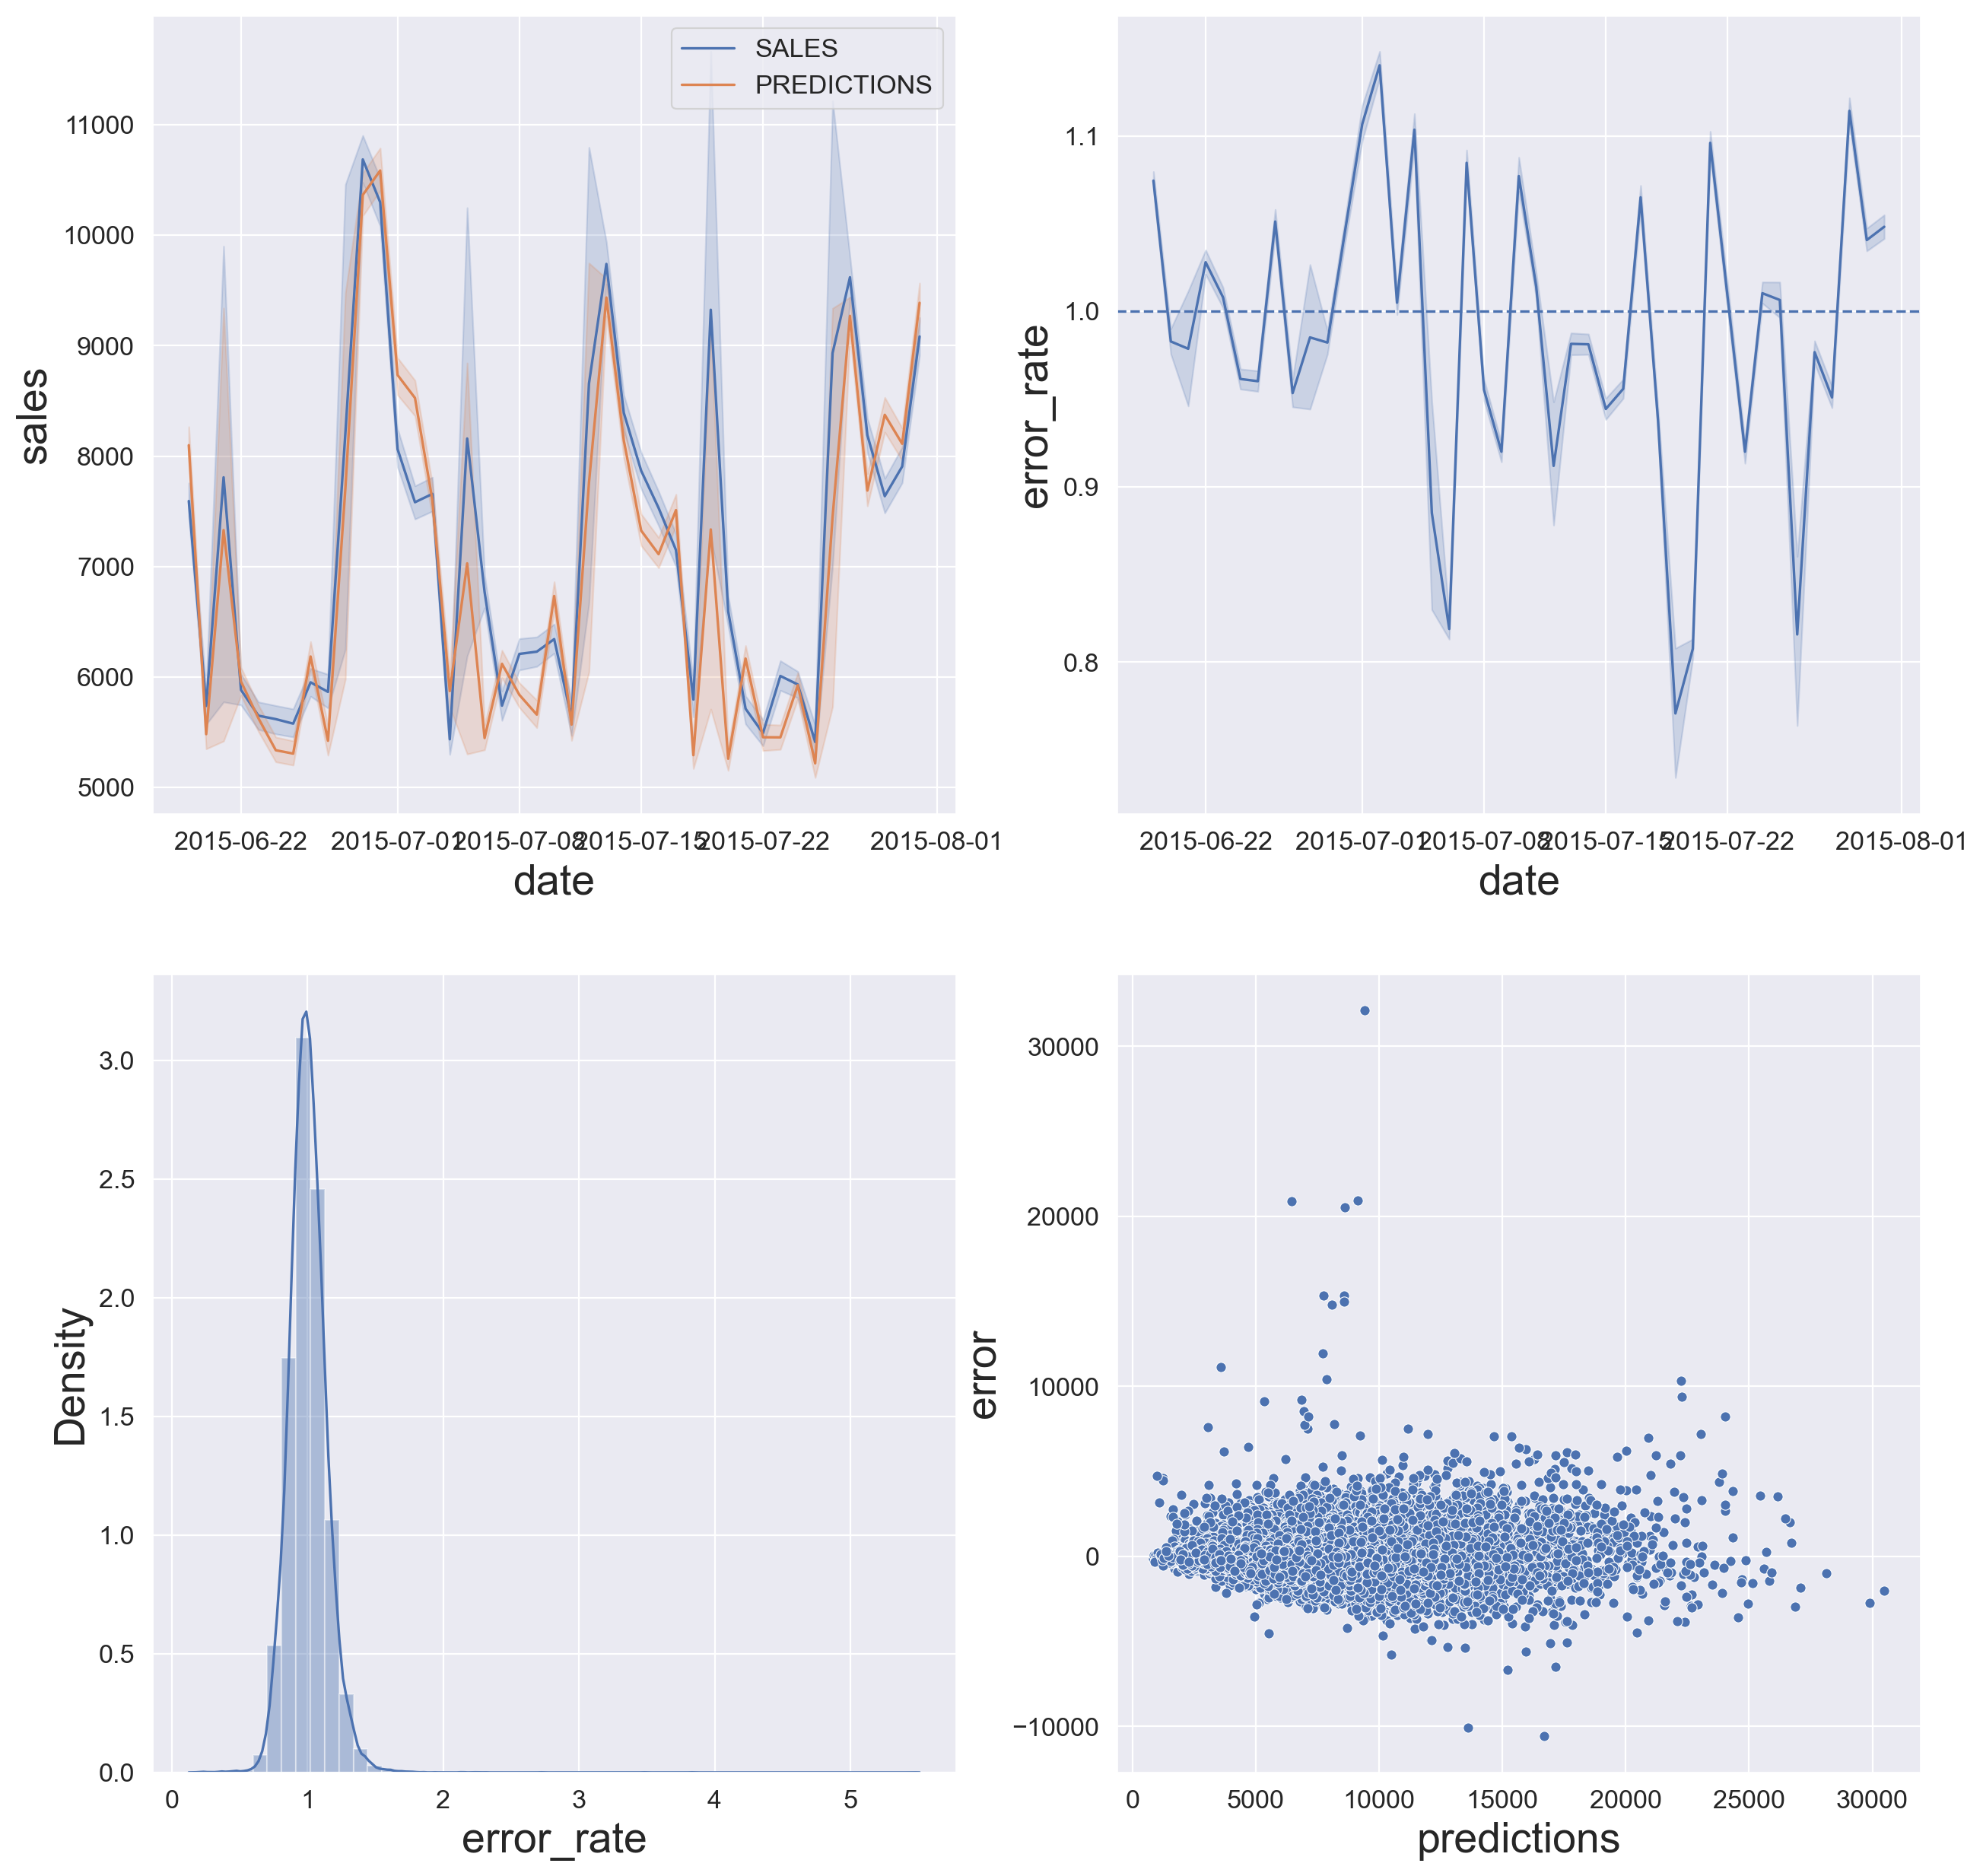

In [123]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error_rate'])
            
plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error']);

# 10.0 - PASSO 10 - Deploy Model to Production

In [133]:
#Save Trained Model
pickle.dump(model_xgb_tuned, open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\model\\model_rossmann.pkl', 'wb'))

## 10.1 - PASSO 10 - Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\parameter\\store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df1):

        ## 1.1 - Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        ## 1.3 - Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 - Fillout NA

        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if  x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 - Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

        return df1


    def feature_engineering(self, df2):
        
        # 3.0 - PASSO 03 - Filtragem de variáveis
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 - PASSO 03 - Filtragem de variáveis
        ## 3.1 - Filtragem das linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2 - Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):

        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1 - Encoding
        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 - Nature Transformation
        #day of week
        df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))
        #month
        df5['month_sen'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

        #day
        df5['day_sen'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

        #week of year
        df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sen', 'day_of_week_cos', 'month_cos', 'day_sen', 'day_cos', 'week_of_year_cos']

                
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 - PASSO 10 - API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\model\\model_rossmann.pkl', 'rb')

#initialize API
app = Flask( __name__ )

@app.route('\\rossmann\\predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_jason()
    
    if test_json: #theere is data
        if isinstance(test_json, dict):
            #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            #multiple example
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        #instantiate Rossmann class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
         
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 10.3 - PASSO 10 - API Tester

In [ ]:
import requests

In [ ]:
#loading tet dataset
df10 = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\test.csv')

In [ ]:
#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([24, 32, 27])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
#convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-test-22.herokuapp.com/rossmann/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

In [ ]:
for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))